In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import fsolve
import pandas as pd
import math
import os
from timer import Timer
from scipy.interpolate import CubicSpline, UnivariateSpline

In [2]:
def GetXi(dphidt, Iterm, a, H, sigmaB):
    #print("H: ", H, "  dphidt: ", dphidt)
    return (Iterm * dphidt + a**alpha*sigmaB)/(2*H)

def GetS(a, H, sigmaE):
    #print(H)
    return a**(alpha) * sigmaE / (2*H)

In [49]:
def BoundaryComputations(kh, dphidt, ddphiddt,
                         Iterm, I2term, a, H, ntr, sigmaE=0, sigmaB=0, delta=1, approx=False):
    xi = GetXi(dphidt, Iterm, a, H, sigmaB)
    s = GetS(a, H, sigmaE)
    
    r = (abs(xi) + np.sqrt(xi**2 + s**2 + s))
    f = a**(1-alpha) * H * (r)
    
    
    def g(x):
        if (x < 0):
            return -1
        elif (x > 0):
            return 1
        else:
            return 0
    
    dsigmadt = 0.
        #approximation: dHdt = alphaH**2 (slow-roll)
    fprime = ((1-alpha)*H*f 
                  + a**(1-alpha)*(I2term*dphidt**2/2 + Iterm*ddphiddt/2)*(g(xi) + xi/np.sqrt(xi**2 + s**2 + s))
                  + a*(alpha*H*sigmaE + dsigmadt)*(s + 1/2)/(2*np.sqrt(xi**2 + s**2 + s))
                  + a**(1-alpha)*H**2*alpha*s/(2*np.sqrt(xi**2 + s**2 + s)))
    #fprime = f*H
    
    if (fprime >= 0):
        if((kh-f)/kh <=1e-3):
            dlnkhdt = fprime/kh
        else:
            dlnkhdt = 0
            #dlnkhdt = H
    else:
        dlnkhdt = 0
    
    bdrF = ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, delta, approx)
    
    return kh, dlnkhdt, bdrF
    

In [4]:
def ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, delta, approx=False):
        
    prefac = dlnkhdt * delta/ (4*np.pi**2)
    
    if approx:
        if (xi>0):
            EtermPlus = approxPosE(xi)
            EtermMinus = approxMinE(xi)
        
            BtermPlus = approxPosB(xi)
            BtermMinus = approxMinB(xi)
        
            GtermPlus = approxPosG(xi)
            GtermMinus = approxMinG(xi)
        elif (xi<0):
            EtermMinus = approxPosE(xi)
            EtermPlus = approxMinE(xi)
        
            BtermMinus = approxPosB(xi)
            BtermPlus = approxMinB(xi)
        
            GtermMinus = approxPosG(xi)
            GtermPlus = approxMinG(xi)
        else:
            EtermPlus = 1
            EtermMinus = 1
            
            GtermPlus = 0
            GtermMinus = 0
            
            BtermPlus = 1
            BtermMinus = 1
    
    else:
        Whitt1Plus = whitw(-xi*(1j), 1/2 + s, -2j*r)
        Whitt2Plus = whitw(1-xi*(1j), 1/2 + s, -2j*r)

        Whitt1Minus = whitw(xi*(1j), 1/2 + s, -2j*r)
        Whitt2Minus = whitw(1+xi*(1j), 1/2 + s, -2j*r)
    
        exptermPlus = np.exp(np.pi*xi)
        exptermMinus = np.exp(-np.pi*xi)

        EtermPlus = exptermPlus*abs((1j*r - 1j*xi -s) * Whitt1Plus + Whitt2Plus)**2/r**2
        EtermMinus = exptermMinus*abs((1j*r + 1j*xi -s) * Whitt1Minus + Whitt2Minus)**2/r**2

        BtermPlus = exptermPlus*abs(Whitt1Plus)**2
        BtermMinus = exptermMinus*abs(Whitt1Minus)**2

        GtermPlus = exptermPlus*((Whitt2Plus*Whitt1Plus.conjugate()).real - s * abs(Whitt1Plus)**2)/r
        GtermMinus = exptermMinus*((Whitt2Minus*Whitt1Minus.conjugate()).real - s * abs(Whitt1Minus)**2)/r

    
    bdrF = np.zeros((ntr, 3))

    for i in range(ntr):
        scale = (kh/a)**(i+4)
        bdrF[i, 0] = prefac*scale*(EtermPlus + (-1)**i * EtermMinus)
        bdrF[i, 1] = prefac*scale*(BtermPlus + (-1)**i * BtermMinus)
        bdrF[i, 2] = prefac*scale*(GtermPlus - (-1)**i * GtermMinus)

    return bdrF

In [5]:
def approxPosE(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (3/2)**(1/3)*g1/(np.pi*xi**(1/3))
    t2 = -np.sqrt(3)/(15*xi)
    t3 = (2/3)**(1/3)*g2/(100*np.pi*xi**(5/3))
    t4 = (3/2)**(1/3)*g1/(1575*np.pi*xi**(7/3))
    t5 = -27*np.sqrt(3)/(19250*xi**3)
    t6 = 359*(2/3)**(1/3)*g2/(866250*np.pi*xi**(11/3))
    t7 = 8209*(3/2)**(1/3)*g1/(13162500*np.pi*xi**(13/3))
    t8 = -690978*np.sqrt(3)/(1861234375*xi**5)
    t9 = 13943074*(2/3)**(1/3)*g2/(127566140625*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinE(xi):
    t1 = 1
    t2 = -9/(2**(10)*xi**2)
    t3 = 2059/(2**(21)*xi**4)
    t4 = -448157/(2**31*xi**6)
    return np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosB(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (2/3)**(1/3)*g2*xi**(1/3)/(np.pi)
    t2 = 2*np.sqrt(3)/(35*xi)
    t3 = -4*(2/3)**(1/3)*g2/(225*np.pi*xi**(5/3))
    t4 = 9*(3/2)**(1/3)*g1/(1225*np.pi*xi**(7/3))
    t5 = 132*np.sqrt(3)/(56875*xi**3)
    t6 = -9511*(2/3)**(1/3)*g2/(5457375*np.pi*xi**(11/3))
    t7 = 1448*(3/2)**(1/3)*g1/(1990625*np.pi*xi**(13/3))
    t8 = 1187163*np.sqrt(3)/(1323765625*xi**5)
    t9 = -22862986*(2/3)**(1/3)*g2/(28465171875*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinB(xi):
    t1 = 1
    t2 = 11/(2**(10)*xi**2)
    t3 = -2397/(2**(21)*xi**4)
    t4 = 508063/(2**31*xi**6)
    return 1/np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosG(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = 1/np.sqrt(3)
    t2 = -(2/3)**(1/3)*g2/(10*np.pi*xi**(2/3))
    t3 = 3*(3/2)**(1/3)*g1/(35*np.pi*xi**(4/3))
    t4 = -np.sqrt(3)/(175*xi**2)
    t5 = -41*(2/3)**(1/3)*g2/(34650*np.pi*xi**(8/3))
    t6 = 10201*(3/2)**(1/3)*g1/(2388750*np.pi*xi**(10/3))
    t7 = -8787*np.sqrt(3)/(21896875*xi**4)
    t8 = -1927529*(2/3)**(1/3)*g2/(4638768750*np.pi*xi**(14/3))
    t9 = 585443081*(3/2)**(1/3)*g1/(393158390625*np.pi*xi**(16/3))
    t10 = -65977497*np.sqrt(3)/(495088343750*xi**6)
    return t1+t2+t3+t4+t5+t6+t7+t8+t9+t10

def approxMinG(xi):
    t1 = 1
    t2 = -67/(2**(10)*xi**2)
    t3 = 21543/(2**(21)*xi**4)
    t4 = -6003491/(2**31*xi**6)
    return -np.sqrt(2)/(32*abs(xi))*(t1 + t2 + t3 + t4)
    
    

In [6]:
def EoMF(dphidt, Iterm, F, bdrF, a, H, sigmaE, sigmaB, kh):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    #print(dphidt, Iterm, F, bdrF, a, H, sigma, kh)
    
    ntr = F.shape[0]
    
    dFdt = np.zeros(F.shape)
    #print(F[0,:])
    #print(F[1,:])
    #print(bdrF[0,:])
    for n in range(ntr-1):
        dFdt[n,0] = (bdrF[n, 0] - ((4+n)*H + 2*a**(alpha) * sigmaE)*F[n,0]
                     - 2*a**(alpha)*F[n+1,2] + 2*(Iterm*dphidt+a**alpha*sigmaB)*F[n,2])
        
        dFdt[n,1] = bdrF[n, 1] - ((4+n)*H)*F[n,1] + 2*a**(alpha)*F[n+1,2]
        
        dFdt[n,2] = (bdrF[n, 2] - ((4+n)*H + a**(alpha) * sigmaE)*F[n,2]
                     + a**(alpha)*(F[n+1,0] - F[n+1,1]) + (Iterm*dphidt+a**alpha*sigmaB)*F[n,1])
        
    
    #print("dFdt[0,0]: ", dFdt[0,0])
    #print("Bdr: ", bdrF[0, 0], ", -4HF00: ", -4*H*F[0,0], ", -F12: ", - 2*a**(alpha)*F[1,2], ", 2IdphidtF02: ", 2*Iterm*F[0,2]*dphidt)
        
    #print("before: ", dFdt[0,:])    
    #print(dFdt)
    #print(bdrF)
    
    
    dFdt[-1,:] = EoMFtruncate(dphidt, Iterm, F[-1,:], F[-2,:], bdrF[-1,:], a, H, sigmaE, sigmaB, kh, ntr-1)
    
    #print("F: ", F[0,0], F[0,1], F[0,2])
    #print("after: ", dFdt[0,0], dFdt[0,1], dFdt[0,2])
    #print("bdrF: ", bdrF[0,0], bdrF[0,1], bdrF[0,2])
    #print("F2: ", F[1,0], F[1,1], F[1,2])
    
    return dFdt

In [7]:
def EoMphi(dphidt, Vterm, Iterm, G, a, H, ratio):
    #G: -1/2(EB + BE)
    #sc[0]: phi
    #sc[1]: dphidt
    
    dscdt = np.zeros(2)
    
    dscdt[0] = dphidt
    dscdt[1] = (alpha-3)*H*dphidt - a**(2*alpha)*Vterm - a**(2*alpha)*Iterm*G*ratio**2
    
    return dscdt

In [8]:
def FriedmannEq(a, dphidt, V, E, B, rhoChi, f, ratio):
    #E: EE
    #B: BB
    #sc[0]: phi
    #sc[1]: dphidt
    
    Hsq = (f**2/(3*Mpl**2)) * (0.5 * dphidt**2 + a**(2*alpha) * V + 0.5*a**(2*alpha)* (E+B)*ratio**2 
                               + ratio**2*rhoChi*a**(2*alpha))
    
    return Hsq

In [9]:
def EoMFtruncate(dphidt, Iterm, F, Fmin1, bdrF, a, H, sigmaE, sigmaB, kh, ntr):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    dFdt = np.zeros(3)
    
    dFdt[0] = (bdrF[0] -  ((4+ntr)*H + 2*a**(alpha) * sigmaE)*F[0]
                         - 2*kh**2 * a**(alpha-2)*Fmin1[2] + 2*(Iterm*dphidt+a**alpha*sigmaB)*F[2])
    dFdt[1] = bdrF[1] - (4+ntr)*H*F[1] + 2*kh**2 * a**(alpha-2)*Fmin1[2]
    dFdt[2] = (bdrF[2] - ((4+ntr)*H + a**(alpha) * sigmaE)*F[2] 
                         + kh**2 * a**(alpha-2)*(Fmin1[0] - Fmin1[1]) + (Iterm*dphidt+a**alpha*sigmaB)*F[1])
    
    return dFdt

In [10]:
def ComputeSigma(E0, B0, H, ratio):
    mu = ((E0+B0)/2)**(1/4)
    gmz = 0.35
    mz = 91.2/(1.220932e19)
    if mu==0:
         return 0
    else:
        gmu = np.sqrt(gmz**2/(1 + gmz**2*41/(48*np.pi**2)*np.log(mz/(mu*ratio))))
        sigma = (41*gmu**3/(72*np.pi**2)
             * np.sqrt(B0)/(H * np.tanh(np.pi*np.sqrt(B0/E0))))
        return sigma
    
def ComputeImprovedSigma(E0, B0, G0, H, ratio):
    mu = ((E0+B0)/2)**(1/4)
    gmz = 0.35
    mz = 91.2/(1.220932e19)
    Sigma = np.sqrt((E0 - B0)**2 + 4*G0**2)
    if mu==0:
         return 0, 0
    else:
        Eprime = np.sqrt(E0-B0+Sigma)
        Bprime = np.sqrt(B0-E0+Sigma)
        Sum = E0 + B0 + Sigma
        gmu = np.sqrt(gmz**2/(1 + gmz**2*41/(48*np.pi**2)*np.log(mz/(mu*ratio))))
        sigma = (41*gmu**3/(72*np.pi**2)
                 /(np.sqrt(Sigma*Sum)*H * np.tanh(np.pi*np.sqrt(Bprime/Eprime))))
        sigmaE = abs(G0)*Eprime*sigma
        sigmaB = -G0*Bprime*sigma
        if (np.isnan(sigmaE) or np.isnan(sigmaB)):
            print("sigma", sigmaE, sigmaB)
            print("field", E0, B0, G0)
        return sigmaE, sigmaB
    

def EoMDelta(sigmaE, a, delta):
    return -a**(alpha)*sigmaE*delta

# Full GEF without Schwinger Effect Wrapper

In [11]:
def fullGEF_NoSE(t, y, omega=1, f=1, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: a
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4 + 3*k]: ErotnE
        #y[4 + 3*k+1]: BrotnB
        #y[4 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ratio = omega/f
    ntr = int((y.size - 4)/3)
    
    dydt = np.zeros(y.shape)

    #print("phi", y[1])
    
    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    #print("sc", sc)
    
    #Cut Off scale:
    lnkh = y[3]
    #print("lnkh", lnkh)
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[4:]
    F = F.reshape(ntr, 3)
    
    #print("F", F)
    
    #print(F[-1,0])
    
    #print("F", F[0,:])
    
    #compute H, potential, couplings and derivatives (once per timestep)
    ## Source of Error?
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)
    dIdsc, ddIddsc = f*dIdphi(f*sc[0]), f**2*ddIddphi(f*sc[0])
    ## Source of error?
    #print("Pots: ", V, dVdsc, dIdsc, ddIddsc)
    #print("Hsq in: ", a, sc[1], V, F[0,0], F[0,1])
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1], 0., f, ratio)
    """if(Hsq<0):
        print("Hsq:", Hsq)
        print("loga:", y[0])
        print("t", t)"""
    #print("Hsq :", Hsq)
    
    #print("Hsq: ", Hsq)
    H = np.sqrt(Hsq)
    
    dydt[0] = H
    
    #print("dadt", dadt)
    
    
    #print("a: ", a)
    
    #Error: evol of dphidt?
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    kh, dydt[3], bdrF = BoundaryComputations(np.exp(y[3]), dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, 0., 0., 1.0, approx=approx)
    #print(kh)
    
    #print("dlnkhdt", dydt[3])
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, 0., 0., kh)
    dydt[4:] = dFdt.reshape(ntr*3)
    #print("dFdt", dFdt[0,:])
    #print("dydt: ", dydt)
    return dydt
    

# Full GEF with Combined Schwinger Effect Wrapper

In [12]:
def fullGEF_SE_mixed(t, y, frac=0.5, omega=1, f=1, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: a
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4]: Delta
        #y[5]: rhoChi
        #y[6 + 3*k]: ErotnE
        #y[6 + 3*k+1]: BrotnB
        #y[6 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ratio = omega/f
    ntr = int((y.size - 6)/3)
    
    dydt = np.zeros(y.shape)

        
    #print("phi", y[1])
    
    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    #print("sc", sc)
    
    #Cut Off scale:
    lnkh = y[3]
    #print("lnkh", lnkh)
    
    #Integrated Conductivity
    delta = y[4]
    
    #Fermion Energy Density:
    rhoChi = y[5]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[6:]
    F = F.reshape(ntr, 3)
    
    #print("F", F)
    
    #print(F[-1,0])
    
    #print("F", F[0,:])
    
    #compute H, potential, couplings and derivatives (once per timestep)
    ## Source of Error?
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)
    dIdsc, ddIddsc = f*dIdphi(f*sc[0]), f**2*ddIddphi(f*sc[0])
    ## Source of error?
    #print("Pots: ", V, dVdsc, dIdsc, ddIddsc)
    #print("Hsq in: ", a, sc[1], V, F[0,0], F[0,1])
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1], rhoChi, f, ratio)
    """if(Hsq<0):
        print("Hsq:", Hsq)
        print("loga:", y[0])
        print("EM:", (F[0,0]+F[0,1])/2)
        print("rhoChi", rhoChi)
        print("Inf", 0.5*sc[1]**2+V)
        print("t", t)"""
    
    H = np.sqrt(Hsq)
    dydt[0] = H
    #print("a: ", a)
    
    #Error: evol of dphidt?
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    #print("dscdt", dscdt)
    sigmaE, sigmaB = ComputeImprovedSigma(F[0,0], F[0,1], F[0,2], H*a**(-alpha), ratio)
    """sigma = ComputeSigma(F[0,0], F[0,1], H*a**(-alpha), ratio)
    if (sigma == 0):
        sigmaE = 0.
        sigmaB = 0.
    else:
        sigmaE = sigma*frac
        sigmaB = - np.sign(F[0,2])*sigma*np.sqrt(F[0,0]/F[0,1])*(1-frac)"""
    
    kh, dydt[3], bdrF = BoundaryComputations(np.exp(y[3]), dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, sigmaE, sigmaB, delta, approx=approx)
    #print(kh)
    
    dydt[4] = EoMDelta(sigmaE, a, delta)
    
    dydt[5] = a**(alpha)*(sigmaE*F[0,0] - sigmaB*F[0,2])  - 4*H*rhoChi
    
    #print("dlnkhdt", dydt[3])
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, sigmaE, sigmaB, kh)
    dydt[6:] = dFdt.reshape(ntr*3)
    #print("dFdt", dFdt[0,:])
    #print("dydt: ", dydt)
    return dydt
    

# Full GEF with Schwinger Effect Wrapper

In [13]:
def fullGEF_SE_electric(t, y, omega=1, f=1, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: a
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4]: Delta
        #y[5]: rhoChi
        #y[6 + 3*k]: ErotnE
        #y[6 + 3*k+1]: BrotnB
        #y[6 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ratio = omega/f
    ntr = int((y.size - 6)/3)
    
    dydt = np.zeros(y.shape)

        
    #print("phi", y[1])
    
    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    #print("sc", sc)
    
    #Cut Off scale:
    lnkh = y[3]
    #print("lnkh", lnkh)
    
    #Integrated Conductivity
    delta = y[4]
    
    #Fermion Energy Density:
    rhoChi = y[5]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[6:]
    F = F.reshape(ntr, 3)
    
    #print("F", F)
    
    #print(F[-1,0])
    
    #print("F", F[0,:])
    
    #compute H, potential, couplings and derivatives (once per timestep)
    ## Source of Error?
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)
    dIdsc, ddIddsc = f*dIdphi(f*sc[0]), f**2*ddIddphi(f*sc[0])
    ## Source of error?
    #print("Pots: ", V, dVdsc, dIdsc, ddIddsc)
    #print("Hsq in: ", a, sc[1], V, F[0,0], F[0,1])
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1], rhoChi, f, ratio)
    """if(Hsq<0):
        print("Hsq:", Hsq)
        print("loga:", y[0])
        print("t", t)"""
    
    #print("dadt", dadt)
    
    H = np.sqrt(Hsq)
    dydt[0] = H
    #print("a: ", a)
    
    #Error: evol of dphidt?
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    #print("dscdt", dscdt)
    sigma = ComputeSigma(F[0,0], F[0,1], H*a**(-alpha), ratio)
    
    kh, dydt[3], bdrF = BoundaryComputations(np.exp(y[3]), dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, sigma, 0, delta, approx=approx)
    #print(kh)
    
    dydt[4] = EoMDelta(sigma, a, delta)
    
    dydt[5] = a**(alpha)*sigma*F[0,0]  - 4*H*rhoChi
    
    #print("dlnkhdt", dydt[3])
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, sigma, 0., kh)
    dydt[6:] = dFdt.reshape(ntr*3)
    #print("dFdt", dFdt[0,:])
    #print("dydt: ", dydt)
    return dydt
    

In [14]:
def fullGEF_SE_magnetic(t, y, omega=1, f=1, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: a
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4]: rhoChi
        #y[5 + 3*k]: ErotnE
        #y[5 + 3*k+1]: BrotnB
        #y[5 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ratio = omega/f
    ntr = int((y.size - 5)/3)
    
    dydt = np.zeros(y.shape)
    
    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    
    #Cut Off scale:
    lnkh = y[3]
    
    #Fermion Energy Density:
    rhoChi = y[4]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[5:]
    F = F.reshape(ntr, 3)
    
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)
    dIdsc, ddIddsc = f*dIdphi(f*sc[0]), f**2*ddIddphi(f*sc[0])
    
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1], rhoChi, f, ratio)
    """if(Hsq<0):
        print("Hsq:", Hsq)
        print("loga:", y[0])
        print("t", t)"""
    
    H = np.sqrt(Hsq)
    dydt[0] = H
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    if (F[0,1] == 0.):
        sigma = 0.
    else:
        sigma = ComputeSigma(F[0,0], F[0,1], H*a**(-alpha), ratio)*np.sqrt(F[0,0]/F[0,1])# *(-1.)* np.sign(F[0,2])
    
    kh, dydt[3], bdrF = BoundaryComputations(np.exp(y[3]), dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, 0., sigma, 1.0, approx=approx)
    
    dydt[4] = -a**(alpha)*sigma*F[0,2]  - 4*H*rhoChi
    
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, sigma, 0., kh)
    dydt[5:] = dFdt.reshape(ntr*3)
    
    return dydt
    

# Const H Wrapper

In [15]:
def ConstHGEF(y, t, HConst, dVdsc, dIdsc, omega=1, f=1, approx=False):
    #y: a 3*ntr + 2 array containing:
        #y[0]: xi
        #y[1]: lnkh
        #y[2 + 3*k]: ErotnE
        #y[2 + 3*k+1]: BrotnB
        #y[2 + 3*k+2]:1/2( ErotnB + BrotnE )
    #Hconst: Constant H value in physical time
    #dVdcs: constant potential value
    ratio = omega/f
    #Corresponds to ntr-1 
    ntr = int((y.size - 2)/3)
    #print(ntr)
    
    dVdsc = dVdsc/(omega**2*f)
    dIdsc = f*dIdsc
    
    dydt = np.zeros(y.shape)
    
    #Scale Factor
    a = np.exp(HConst*t)
    #print(a)
    #H value in alpha-time
    H = a**(alpha)*HConst
    #print(a)
    #print(t)
    
    #Cut Off scale:
    lnkh = y[1]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[2:]
    F = F.reshape(ntr, 3)
    #print(F[0,:])
    #print(F)
    
    #print("a: ", a)
    
    dphidt = 2*y[0]/dIdsc
    #print(y[0])
    ddphiddt = EoMphi(dphidt, dVdsc, dIdsc, F[0,2], a, H, ratio)[1]
    dydt[0] = dIdsc*ddphiddt/(2*H) - alpha*H*y[0]
    
    kh, dydt[1], bdrF = BoundaryComputations(np.exp(y[1]), dphidt, ddphiddt, dIdsc, 0., a, H, ntr, approx=approx)
    #print(bdrF)
    #print(np.exp(y[1]))
    #print(dphidt)
    dFdt = EoMF(dphidt, dIdsc, F, bdrF, a, H, 0., kh)
    #print(dFdt[0,:])
    #print(dFdt[1,:])
    dydt[2:] = dFdt.reshape(ntr*3)
    
    return dydt

# Regular Inflation Wrapper

In [16]:
def Inflation(y, omega=1, f=1):
    #y: a 3 array containing:
        #y[0]: lna
        #y[1]: phi
        #y[2]: dphidt
        
    ratio = omega/f
    
    dydt = np.zeros(y.shape)

    #Scale Factor
    a = np.exp(y[0])
    
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    
    V, dVdsc = potential(f*sc[0])/(f*omega)**2, dVdphi(f*sc[0])/(omega**2*f)

    Hsq = FriedmannEq(a, sc[1], V, 0, 0, 0., f, ratio)
    
    dydt[0] = np.sqrt(Hsq)
    
    H = np.sqrt(Hsq)
    
    dscdt = EoMphi(sc[1], dVdsc, 0., 0., a, H, ratio)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]

    return dydt

In [17]:
def PlotComp(ax1, ax2, N, Y, Nref, Yref, col="k:", label=None, interp="lin"):
    ax1.plot(N, Y, col, label=label)
    ax1.set_xlabel(r"$N_e$")
    if interp=="cubic":
        spl = CubicSpline(N, Y)
        ax2.plot(Nref, abs(spl(Nref)/Yref-1), col)
    else:
        spl = np.interp(Nref, N, Y)
        ax2.plot(Nref, abs(spl/Yref-1), col)
    ax2.set_yscale("log")
    ax2.set_ylabel("rel. err.")
    ax2.set_xlabel(r"$N_e$")
    return

In [18]:
def GetPhysQuantities(sol, Iterm, omega, f, SE=None, units=True):
    N = sol.y[0,:]
    a = np.exp(N)
    phi = sol.y[1,:]
    dphidt = sol.y[2,:]
    kh = np.exp(sol.y[3,:])
    V = potential(f*phi)/(f*omega**2)
    print(SE)
    ratio = omega/f
    if SE==None:
        E = sol.y[4,:]
        B = sol.y[5,:]
        G = sol.y[6,:]
        H = np.sqrt(FriedmannEq(a, dphidt, V, E, B, 0., f, ratio))
        xi = GetXi(dphidt, Iterm, a, H, 0.)
        if units:
            phi = f*phi
            dphidt = omega*f*phi
            kh = kh*omega
            V = V*f**2*omega**2
            E = E*omega**4
            B = B*omega**4
            G = G*omega**4
            H = H*omega
        return N, a, phi, dphidt, kh, E, B, G, V, H, xi
    elif SE=="mag":
        rhoChi = sol.y[4,:]
        E = sol.y[5,:]
        B = sol.y[6,:]
        G = sol.y[7,:]
        H = np.sqrt(FriedmannEq(a, dphidt, V, E, B, rhoChi, f, ratio))
        sigma = np.array([ComputeSigma(E[i], B[i], H[i], ratio)*np.sqrt(E[i]/B[i]) for i in range(len(E))])
        xi = GetXi(dphidt, Iterm, a, H, 0.)
        if units:
            phi = f*phi
            dphidt = omega*f*dphidt
            kh = kh*omega
            V = V*f**2*omega**2
            rhoChi = rhoChi*omega**4
            E = E*omega**4
            B = B*omega**4
            G = G*omega**4
            H = H*omega
            sigma = omega*sigma
        return N, a, phi, dphidt, kh, rhoChi, E, B, G, V, H, xi, sigma
    else: 
        delta = sol.y[4,:]
        rhoChi = sol.y[5,:]
        E = sol.y[6,:]
        B = sol.y[7,:]
        G = sol.y[8,:]
        H = np.sqrt(FriedmannEq(a, dphidt, V, E, B, rhoChi, f, ratio))
        if SE=="elc":
            sigma = np.array([ComputeSigma(E[i], B[i], H[i], ratio) for i in range(len(E))])
            xi = GetXi(dphidt, Iterm, a, H, 0.)
            if units:
                phi = f*phi
                dphidt = omega*f*dphidt
                kh = kh*omega
                V = V*f**2*omega**2
                rhoChi = rhoChi*omega**4
                E = E*omega**4
                B = B*omega**4
                G = G*omega**4
                H = H*omega
                sigma = omega*sigma
            return N, a, phi, dphidt, kh, delta, rhoChi, E, B, G, V, H, xi, sigma
        if SE=="mix":
            sigmaE = np.array([ComputeImprovedSigma(E[i], B[i], G[i], H[i], ratio)[0] for i in range(len(E))])
            sigmaB = np.array([ComputeImprovedSigma(E[i], B[i], G[i], H[i], ratio)[1] for i in range(len(E))])
            xi = GetXi(dphidt, Iterm, a, H, 0.)
            if units:
                phi = f*phi
                dphidt = omega*f*dphidt
                kh = kh*omega
                V = V*f**2*omega**2
                rhoChi = rhoChi*omega**4
                E = E*omega**4
                B = B*omega**4
                G = G*omega**4
                H = H*omega
                sigmaE = omega*sigmaE
                sigmaB = omega*sigmaB
            return N, a, phi, dphidt, kh, delta, rhoChi, E, B, G, V, H, xi, sigmaE, sigmaB
        

In [19]:
def EndOfInflation(t, a, H, tol=1e-6):
    N = np.log(a)
    n = int(len(t)/10)
    
    """d2Ndt2 = (N[2:]/(t[2:]-t[1:-1]) 
              - N[1:-1]*(t[2:]-t[:-2])/((t[2:]-t[1:-1])*(t[1:-1]-t[:-2]))
              + N[:-2]/(t[1:-1]-t[:-2]) 
             )/(t[1:-1]-t[:-2])
    
    f = CubicSpline(N[n:-2], d2Ndt2[n:] + H[n:-2]**2)"""
    
    dHdt = (H[1:] - H[:-1])/(t[1:]-t[:-1])
    
    f = CubicSpline(N[n:-1], dHdt[n:]/H[n:-1]**2 + 1)
    
    delN = 1.
    RefineGrid = True
    r0 = 40.
    while RefineGrid:
        print(delN)
        x0 = np.arange(50, max(N[:-2]), delN)
        res = fsolve(f, x0, xtol=tol)
        N0 = res[0]
        print(res[0])
        fN0 = abs(f(N0))
        for r in res:
            fN1 = abs(f(r))
            if fN1 < fN0:
                fN0 = fN1
                N0 = r
        r1 = np.round(N0, 2)
        print(r1)
        if r1 == r0:
            RefineGrid=False
        else:
            r0 = r1
            delN = delN*0.5
            
    return N0, delN

# Full GEF Test

In [51]:
#Set up dim-full quantities
alpha = 0
beta = 25.
Mpl = 1
M = 6e-6*Mpl
phi0 = 15.55*Mpl #in Pl units
dphidt0 = -np.sqrt(2/3)*M*Mpl

rhoChi = 0.

Delta0 = 1.

E0 = 0#data[0,1]*100
B0 = 0#data[0,3]*100"""

def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2

H = np.sqrt((dphidt0**2/2 + potential(phi0) + 0.5*(E0+B0))/3 +rhoChi)/Mpl
#xi is indep of rescaling, so we can compute it here
print(H)
xi = GetXi(dphidt0, dIdphi(phi0), 1.0, H, 0.)
print(H**4)

3.814203717684728e-05
2.1164866842250005e-18


In [52]:
#setup dimless
omega = H

f = Mpl
ntr = 116
yini = np.zeros(ntr*3+6)
yini[0] = 0.
yini[1] = phi0/f
yini[2] = dphidt0/(f*omega)

yini[3] = np.log(2*abs(xi))

yini[4] = Delta0

yini[5] = rhoChi

zini = np.ones(ntr*3+5)
zini[:4] = yini[:4]
zini[5:] = yini[6:]

In [53]:
wini = yini[:3]
print(wini)
print(omega)

[ 0.         15.55       -0.12844043]
3.814203717684728e-05


In [54]:
from timer import Timer

omega = H
f = Mpl
t1 = Timer()
t2 = Timer()
t3 = Timer()

#electric picture
func = lambda t, x: fullGEF_SE_electric(t, x, f=f, omega=omega)
t1.start()
solA = solve_ivp(func, [0, 150] , yini, method="RK45")#, atol=1e-7, rtol=1e-6)
t1.stop()

#magnetic picture
func = lambda t, x: fullGEF_SE_magnetic(t, x, f=f, omega=omega, approx=True)
t3.start()
solB = solve_ivp(func, [0, 125] , zini, method="RK45")#, atol=1e-7, rtol=1e-6)
t3.stop()

#mixed picture
func = lambda t, x: fullGEF_SE_mixed(t, x, frac=0.5, f=f, omega=omega)
t2.start()
solC = solve_ivp(func, [0, 140] , yini, method="RK45")#, atol=1e-7, rtol=1e-6)
t2.stop()


Elapsed time: 178.6263 seconds
Elapsed time: 151.7058 seconds
Elapsed time: 543.6944 seconds


In [55]:
N1, a1, phi1, dphidt1, kh1, delta1, rhoChi1, E1, B1, G1, V1, H1, xi1, sigma1 = GetPhysQuantities(
    solA, beta, omega, 1., SE="elc", units=False)

data = [solA.t, N1, a1, H1, kh1, phi1, dphidt1, xi1, V1, E1, B1, G1, delta1, rhoChi1, sigma1]

names = ["t","N","a","H","kh","phi","dphidt","xi","V","E","B","G","delta","rhoChi","sigmaE"]
    
DataDic = dict(zip(names, data))

filename = "GEF_Beta25_M6_SE_electric.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(DataDic)  
output_df.to_csv(path)

N1, a1, phi1, dphidt1, kh1, delta1, rhoChi1, E1, B1, G1, V1, H1, xi1, sigmaE1, sigmaB1 = GetPhysQuantities(
    solC, beta, omega, 1., SE="mix", units=False)

data = [solC.t, N1, a1, H1, kh1, phi1, dphidt1, xi1, V1, E1, B1, G1, delta1, rhoChi1, sigmaE1, sigmaB1]

names = ["t","N","a","H","kh","phi","dphidt","xi","V","E","B","G","delta","rhoChi","sigmaE","sigmaB"]
    
DataDic = dict(zip(names, data))

filename = "GEF_Beta25_M6_SE_mixed.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(DataDic)  
output_df.to_csv(path)

N1, a1, phi1, dphidt1, kh1, rhoChi1, E1, B1, G1, V1, H1, xi1, sigma1 = GetPhysQuantities(
    solB, beta, omega, 1., SE="mag", units=False)

data = [solB.t, N1, a1, H1, kh1, phi1, dphidt1, xi1, V1, E1, B1, G1, rhoChi1, sigma1]

names = ["t","N","a","H","kh","phi","dphidt","xi","V","E","B","G", "rhoChi", "sigmaB"]
    
DataDic = dict(zip(names, data))

filename = "GEF_Beta25_M6_SE_magnetic.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(DataDic)  
output_df.to_csv(path)

elc
mix
mag


/tmp/ipykernel_8951/1850913955.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.array([ComputeSigma(E[i], B[i], H[i], ratio)*np.sqrt(E[i]/B[i]) for i in range(len(E))])


In [28]:
N1, a1, phi1, dphidt1, kh1, delta1, rhoChi1, E1, B1, G1, V1, H1, xi1, sigma1 = GetPhysQuantities(
    solA, beta, omega, 1., SE="elc", units=True)
N2, a2, phi2, dphidt2, kh2, delta2, rhoChi2, E2, B2, G2, V2, H2, xi2, sigmaE2, sigmaB2 = GetPhysQuantities(
    solC, beta, omega, 1., SE="mix", units=True)
N3, a3, phi3, dphidt3, kh3, rhoChi3, E3, B3, G3, V3, H3, xi3, sigma3 = GetPhysQuantities(
    solB, beta, omega, 1., SE="mag", units=True)

elc
mix
mag


/tmp/ipykernel_8951/1850913955.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.array([ComputeSigma(E[i], B[i], H[i], ratio)*np.sqrt(E[i]/B[i]) for i in range(len(E))])


(44.0, 61.5)

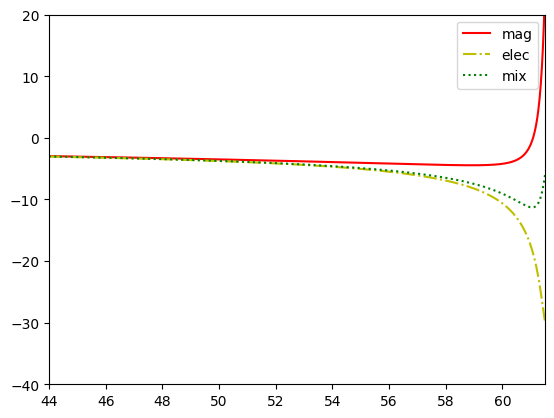

In [29]:
plt.plot(N3, xi3+sigma3/(2*H3) , "r", label="mag")
plt.plot(N1, xi1 , "y-.", label="elec")
plt.plot(N2, xi2+sigmaB2/(2*H2), "g:",label="mix")
#plt.plot(N1, xi1, "y-.",label="elec")
plt.legend(loc=0)
#plt.yscale("symlog")
plt.ylim(-40., 20.)
plt.xlim(44, 61.5)

In [30]:
f1 = CubicSpline(N1, 2*dphidt1**2 - 2*V1 + E1 + B1 + 2*rhoChi1)

Nend1 = fsolve(f1, 61.)
Nend1_a, _ = EndOfInflation(solA.t, a1, H1/omega)
print(Nend1[0], Nend1_a)

f2 = CubicSpline(N2, 2*dphidt2**2 - 2*V2 + E2 + B2 + 2*rhoChi2)

"""Nend2 = fsolve(f2, 61.)
Nend2_a, _ = EndOfInflation(solC.t, a2, H2/omega)
print(Nend2[0], Nend2_a)"""

f3 = CubicSpline(N3, 2*dphidt3**2 - 2*V3 + E3 + B3 + 2*rhoChi3)

Nend3 = fsolve(f3, 61.)
Nend3_a, _ = EndOfInflation(solB.t, a3, H3/omega)
print(Nend3[0], Nend3_a)

1.0
61.01011278964603
61.01
0.5
51.54612705399013
61.0
0.25
49.997553451735165
61.0
61.00841638732335 61.00000435232673
1.0
50.0
61.0
0.5
50.0
61.0
61.008479163433115 61.0


/home/users/rfreiher/.conda/envs/ptarcade/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


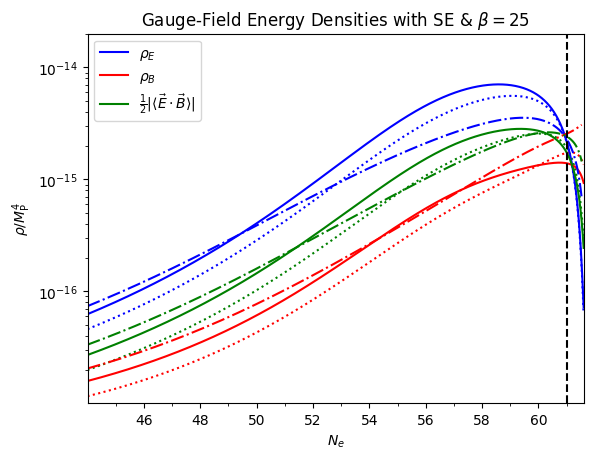

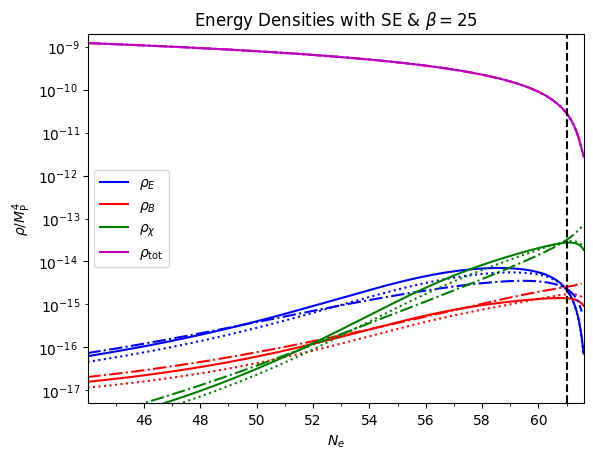

/tmp/ipykernel_8951/1002779775.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(N1, (rhoG1)/np.sqrt(rhoE1*rhoB1), "k:")
/tmp/ipykernel_8951/1002779775.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(N3, (rhoG3)/np.sqrt(rhoE3*rhoB3), "k-.")


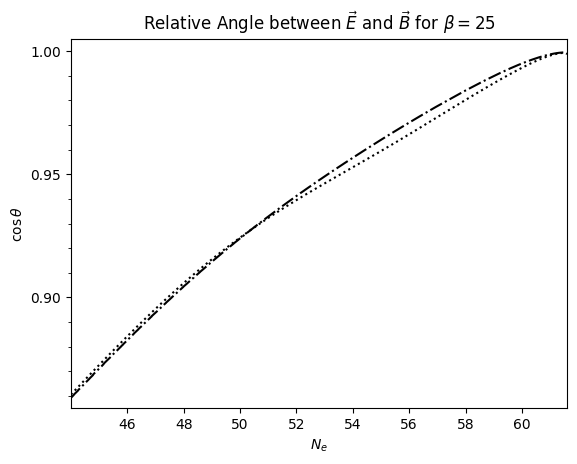

In [31]:
rhoE1 = 0.5*E1
rhoB1 = 0.5*B1
rhoG1 = 0.5*abs(G1)

rhotot1 = rhoE1 + rhoB1 + rhoChi1 + 0.5*dphidt1**2 + potential(phi1)

rhoE2 = 0.5*E2
rhoB2 = 0.5*B2
rhoG2 = 0.5*abs(G2)

rhotot2 = rhoE2 + rhoB2 + rhoChi2 + 0.5*dphidt2**2 + potential(phi2)

rhoE3 = 0.5*E3
rhoB3 = 0.5*B3
rhoG3 = 0.5*abs(G3)

rhotot3 = rhoE3 + rhoB3 + rhoChi3 + 0.5*dphidt3**2 + potential(phi3)

xticks = np.arange(46, 61, 2)
xticksmin = np.arange(45, 62, 2)
yticks = 10**(-1.*np.arange(14, 17))

plt.title("Gauge-Field Energy Densities with SE & " +  r"$\beta=25$")
plt.plot(N1, rhoE1, "b:")
plt.plot(N1, rhoB1, "r:")
plt.plot(N1, rhoG1, "g:")
plt.plot(N2, rhoE2, "b", label=r"$\rho_E$")
plt.plot(N2, rhoB2, "r", label=r"$\rho_B$")
plt.plot(N2, rhoG2, "g", label=r"$\frac{1}{2}|\langle\vec{E}\cdot\vec{B}\rangle|$")
plt.plot(N3, rhoE3, "b-.")
plt.plot(N3, rhoB3, "r-.")
plt.plot(N3, rhoG3, "g-.")
plt.vlines(Nend1, 1e-17, 2e-14, "k", "dashed")
#plt.vlines(Nend2, 1e-17, 2e-14, "k")
plt.legend(loc=0)
plt.yscale("log")
plt.ylabel(r"$\rho/M_\mathrm{P}^4$")
plt.xlabel(r"$N_e$")
#plt.vlines(61., 1e-20, 1e-9, "k")
plt.ylim(1e-17, 2e-14)
plt.xlim(44, 61.6)
plt.xticks(xticks)
plt.xticks(xticksmin, minor=True)
plt.yticks(yticks)
#plt.savefig("SE_Beta25_GaugeFields_RegVSImpr.pdf")
plt.show()


xticks = np.arange(46, 61, 2)
yticks = 10**(-1.*np.arange(10, 18, 2))
yticksmin = 10**(-1.*np.arange(9, 19, 2))

plt.title("Energy Densities with SE & " +  r"$\beta=25$")
plt.plot(N1, rhoE1, "b:")
plt.plot(N1, rhoB1, "r:")
plt.plot(N2, rhoE2, "b", label=r"$\rho_E$")
plt.plot(N2, rhoB2, "r", label=r"$\rho_B$")
plt.plot(N3, rhoE3, "b-.")
plt.plot(N3, rhoB3, "r-.")
plt.plot(N1, rhoChi1, "g:")
plt.plot(N2, rhoChi2, "g", label=r"$\rho_\chi$")
plt.plot(N3, rhoChi3, "g-.")
plt.plot(N1, rhotot1, "m:")
plt.plot(N2, rhotot2, "m", label=r"$\rho_{\mathrm{tot}}$")
plt.plot(N3, rhotot3, "m-.")
plt.vlines(Nend1, 0.5e-17, 2e-9, "k", "dashed")
#plt.vlines(Nend2, 0.5e-17, 2e-9, "k")
plt.legend(loc=0)
plt.yscale("log")
plt.ylabel(r"$\rho/M_\mathrm{P}^4$")
plt.xlabel(r"$N_e$")
#plt.vlines(61., 1e-20, 1e-8, "k")
plt.ylim(0.5e-17, 2e-9)
plt.xlim(44., 61.6)
plt.xticks(xticks)
plt.xticks(xticksmin, minor=True)
plt.yticks(yticks)
plt.yticks(yticksmin, labels=None, minor=True)
#plt.savefig("SE_Beta25_EnergyDensities_RegVSImpr.pdf")
plt.show()

plt.title("Relative Angle between " + r"$\vec{E}$ and $\vec{B}$ for $\beta=25$")
yticks = 0.01*np.arange(90, 105, 5)
yticksmin = 0.01*np.arange(86, 101, 1)
plt.plot(N1, (rhoG1)/np.sqrt(rhoE1*rhoB1), "k:")
#plt.plot(N2, (rhoG2)/np.sqrt(rhoE2*rhoB2), "k")
plt.plot(N3, (rhoG3)/np.sqrt(rhoE3*rhoB3), "k-.")
plt.ylim(0.855, 1.005)
plt.xlim(44., 61.6)
plt.xticks(xticks)
plt.yticks(yticks)
plt.yticks(yticksmin, labels=None, minor=True)
plt.ylabel(r"$\cos \theta$")
plt.xlabel(r"$N_e$")
#plt.savefig("SE_Beta25_Angle_RegVSImpr.pdf")
plt.show()

/home/users/rfreiher/.conda/envs/ptarcade/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


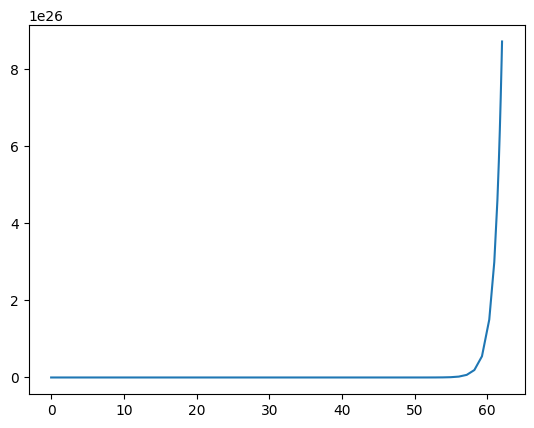

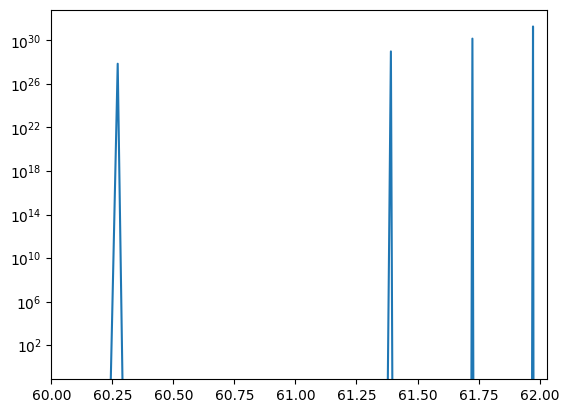

In [23]:
g = lambda t, x: Inflation(x, f=f, omega=omega)

sol2 = solve_ivp(g, [0,150], wini)
a = np.exp(sol2.y[0,:])
spl = UnivariateSpline(sol2.t, a)
a2 = spl.derivative(n=2)
print(a2)

    
plt.plot(sol2.y[0,:], spl(sol2.t))
plt.show()
plt.plot(sol2.y[0,:], a2(sol2.t))
plt.plot(sol2.y[0,:], np.zeros(len(sol2.t)))
plt.xlim(60,max(sol2.y[0,:]))
plt.yscale("log")
plt.show()

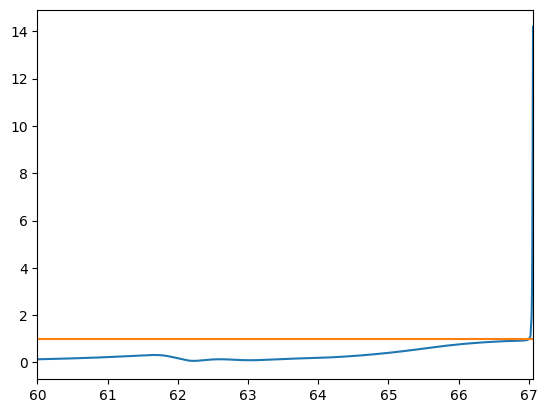

In [34]:
dHdt = (H3[1:]/omega - H3[:-1]/omega)/(solB.t[1:]-solB.t[:-1])

plt.plot(N3[:-1], -dHdt/(H3[:-1]/omega)**2)
plt.plot(N3, np.ones(N3.size))
plt.xlim(60, max(N3))
#plt.ylim(-0.1e-8, 0.15e-7)
plt.show()

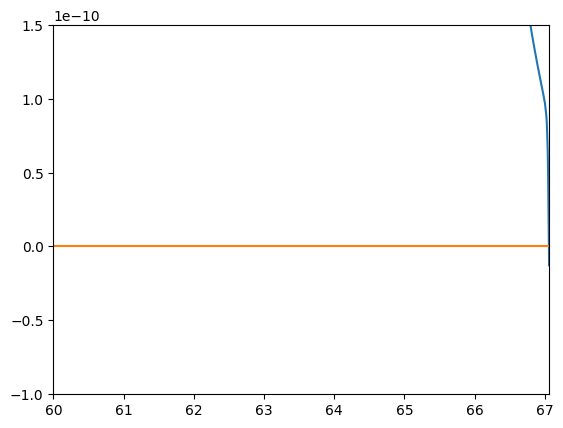

In [39]:
plt.plot(N3, f3(N3))
plt.plot(N3, np.zeros(N3.size))
plt.xlim(60, max(N3))
plt.ylim(-0.1e-9, 0.15e-9)
plt.show()

In [ ]:
N = solA.y[0,:]
rhoE = 0.5*solA.y[6,:]*omega**4
rhoB = 0.5*solA.y[7,:]*omega**4
rhoG = 0.5*abs(solA.y[8,:])*omega**4
rhoChi = solA.y[5,:]*omega**4
rhotot = rhoE + rhoB + rhoChi + 0.5*solA.y[2,:]**2*omega**2/f**2 + potential(solA.y[1,:])

N2 = solB.y[0,:]
rhoE2 = 0.5*solB.y[4,:]*omega**4
rhoB2 = 0.5*solB.y[5,:]*omega**4
rhotot2 =  rhoE2 + rhoB2 + 0.5*solB.y[2,:]**2*omega**2/f**2 + potential(solB.y[1,:])

N3 = solC.y[0,:]
rhoE3 = 0.5*solC.y[6,:]*omega**4
rhoB3 = 0.5*solC.y[7,:]*omega**4
rhoG3 = 0.5*abs(solC.y[8,:])*omega**4
rhoChi3 = solC.y[5,:]*omega**4
rhotot3 = rhoE3 + rhoB3 + rhoChi3 + 0.5*solC.y[2,:]**2*omega**2/f**2 + potential(solC.y[1,:])

In [ ]:
xticks = np.arange(56, 62)
yticks = 10**(-1.*np.arange(16, 20))

plt.title("Gauge-Field Production with SE & " +  r"$\beta=10$")
plt.plot(N, rhoE, "b", label=r"$\rho_E$")
plt.plot(N, rhoB, "r:", label=r"$\rho_B$")
plt.plot(N, rhoG, "g:", label=r"$\frac{1}{2}|\langle\vec{E}\cdot\vec{B}\rangle|$")
plt.plot(N3, rhoE3, "c", label=r"$\rho_E$ Impr.")
plt.plot(N3, rhoB3, "m:", label=r"$\rho_B$ Impr.")
plt.plot(N3, rhoG3, "y:", label=r"$\frac{1}{2}|\langle\vec{E}\cdot\vec{B}\rangle|$ Impr.")
plt.legend(loc=0)
plt.yscale("log")
plt.ylabel(r"$\rho/M_\mathrm{P}^4$")
plt.xlabel(r"$N_e$")
plt.vlines(61, 1e-20, 1e-9, "k")
plt.ylim(0.5e-19, 2e-16)
plt.xlim(55.5, 61.5)
plt.xticks(xticks)
plt.yticks(yticks)
#plt.savefig("SE_Beta10_GaugeFields.pdf")
plt.show()



xticks = np.arange(58, 62)
yticks = 10**(-1.*np.arange(10, 20, 2))

plt.title("Energy Densities with SE & " +  r"$\beta=10$")
plt.plot(N, rhoE, "b:")
plt.plot(N, rhoB, "r:")
plt.plot(N3, rhoE3, "b", label=r"$\rho_E$")
plt.plot(N3, rhoB3, "r", label=r"$\rho_B$")
plt.plot(N, rhoChi, "g:")
plt.plot(N3, rhoChi3, "g", label=r"$\rho_\chi$")
plt.plot(N, rhotot, "m:")
plt.plot(N3, rhotot3, "m", label=r"$\rho_{\mathrm{tot}}$")
plt.legend(loc=0)
plt.yscale("log")
plt.ylabel(r"$\rho/M_\mathrm{P}^4$")
plt.xlabel(r"$N_e$")
plt.vlines(61, 1e-20, 1e-9, "k")
plt.ylim(1e-19, 1e-9)
plt.xlim(57.5, 61.5)
plt.xticks(xticks)
plt.yticks(yticks)
#plt.savefig("SE_Beta10_EnergyDensities.pdf")
plt.show()

plt.title("Relative Angle between " + r"$\vec{E}$ and $\vec{B}$ for $\beta=10$")
yticks = 0.1*np.arange(8, 11)
plt.plot(N, (abs(solA.y[8,:])/np.sqrt(solA.y[6,:]*solA.y[7,:])), "k:")
plt.plot(N3, (abs(solC.y[8,:])/np.sqrt(solC.y[6,:]*solC.y[7,:])), "k")
plt.xlim(57.5, 61.5)
plt.ylim(0.75, 1.01)
plt.xticks(xticks)
plt.yticks(yticks)
plt.ylabel(r"$\cos \theta$")
plt.xlabel(r"$N_e$")
#plt.savefig("SE_Beta10_Angle.pdf")
plt.show()

In [46]:
omega = H
f = Mpl

ntr = [26, 41, 56, 71]
yini = np.zeros(ntr[-1]*3+5)
yini[0] = 0.
yini[1] = phi0/f
yini[2] = dphidt0/(f*omega)

yini[3] = np.log(2*abs(xi))

yini[4] = rhoChi

t1 = Timer()
t2 = Timer()
t3 = Timer()
t4 = Timer()

func = lambda t, x: fullGEF_SE_magnetic(t, x, f=f, omega=omega, approx=True)

t1.start()
sol1 = solve_ivp(func, [0, 125] , yini[:(5+3*ntr[0])], method="RK45")#, atol=1e-7, rtol=1e-6)
t1.stop()

t2.start()
sol2 = solve_ivp(func, [0, 125] , yini[:(5+3*ntr[1])], method="RK45")#, atol=1e-7, rtol=1e-6)
t2.stop()

t3.start()
sol3 = solve_ivp(func, [0, 125] , yini[:(5+3*ntr[2])], method="RK45")#, atol=1e-7, rtol=1e-6)
t3.stop()

t4.start()
sol4 = solve_ivp(func, [0, 125] , yini[:(5+3*ntr[3])], method="RK45")#, atol=1e-7, rtol=1e-6)
t4.stop()


Elapsed time: 15.0049 seconds
Elapsed time: 52.4549 seconds
Elapsed time: 80.1087 seconds
Elapsed time: 101.2812 seconds


mag
mag
mag


/tmp/ipykernel_8951/1850913955.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.array([ComputeSigma(E[i], B[i], H[i], ratio)*np.sqrt(E[i]/B[i]) for i in range(len(E))])


mag


/tmp/ipykernel_8951/1799143840.py:9: RuntimeWarning: invalid value encountered in divide
  ax2.plot(Nref, abs(spl/Yref-1), col)


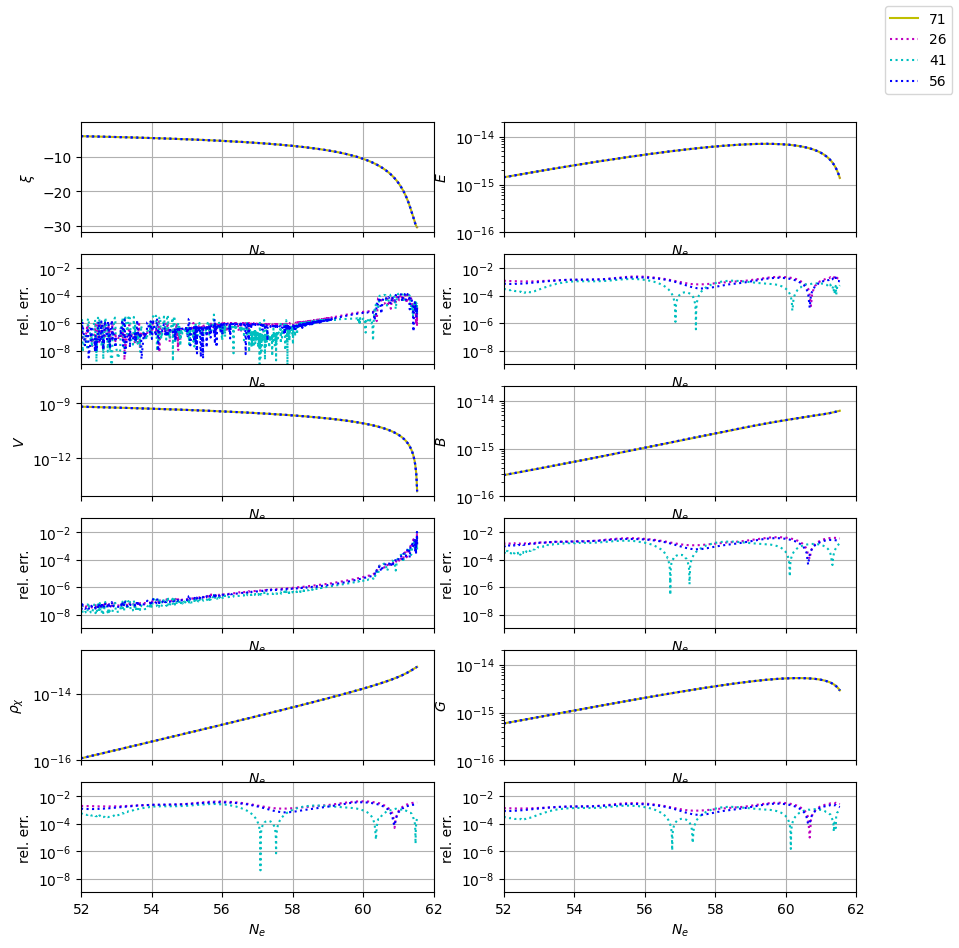

In [48]:
fig, ax = plt.subplots(6,2, figsize=(10,10), sharex=True)
N3, a3, phi3, dphidt3, kh3, rhoChi3, E3, B3, G3, V3, H3, xi3, sigma3
N1, _, _, _, _, rhoChi1, E1, B1, G1, V1, _, xi1, _ = GetPhysQuantities(sol4, beta, omega, f, SE="mag")
N2, _, _, _, _, rhoChi2, E2, B2, G2, V2, _, xi2, _ = GetPhysQuantities(sol2, beta, omega, f, SE="mag")
N3, _, _, _, _, rhoChi3, E3, B3, G3, V3, _, xi3, _ = GetPhysQuantities(sol3, beta, omega, f, SE="mag")
N4, _, _, _, _, rhoChi4, E4, B4, G4, V4, _, xi4, _ = GetPhysQuantities(sol1, beta, omega, f, SE="mag")


ax[0,0].plot(N4, xi4, "y-", label=str(ntr[-1]))
PlotComp(ax[0,0], ax[1,0], N1, xi1, N4, xi4, col="m:", label=str(ntr[0]))
PlotComp(ax[0,0], ax[1,0], N2, xi2, N4, xi4, col="c:", label=str(ntr[1]))
PlotComp(ax[0,0], ax[1,0], N3, xi3, N4, xi4, col="b:", label=str(ntr[2]))
#ax[0,0].set_yscale("log")
ax[0,0].set_ylabel(r"$\xi$")

ax[2,0].plot(N4, abs(V4), "y-", label=str(ntr[-1]))
PlotComp(ax[2,0], ax[3,0], N1, abs(V1), N4, abs(V4), col="m:", label=str(ntr[0]))
PlotComp(ax[2,0], ax[3,0], N2, abs(V2), N4, abs(V4), col="c:", label=str(ntr[1]))
PlotComp(ax[2,0], ax[3,0], N3, abs(V3), N4, abs(V4), col="b:", label=str(ntr[2]))
ax[2,0].set_ylabel(r"$V$")
ax[2,0].set_yscale("log")

ax[4,0].plot(N4, rhoChi4, "y-", label=str(ntr[-1]))
PlotComp(ax[4,0], ax[5,0], N1, rhoChi1, N4, rhoChi4, col="m:", label=str(ntr[0]))
PlotComp(ax[4,0], ax[5,0], N2, rhoChi2, N4, rhoChi4, col="c:", label=str(ntr[1]))
PlotComp(ax[4,0], ax[5,0], N3, rhoChi3, N4, rhoChi4, col="b:", label=str(ntr[2]))
ax[4,0].set_ylabel(r"$\rho_\chi$")
ax[4,0].set_yscale("log")

ax[0,1].plot(N4, E4, "y-", label=str(ntr[-1]))
PlotComp(ax[0,1], ax[1,1], N1, E1, N4, E4, col="m:", label=str(ntr[0]))
PlotComp(ax[0,1], ax[1,1], N2, E2, N4, E4, col="c:", label=str(ntr[1]))
PlotComp(ax[0,1], ax[1,1], N3, E3, N4, E4, col="b:", label=str(ntr[2]))
ax[0,1].set_ylabel(r"$E$")
ax[0,1].set_yscale("log")

ax[2,1].plot(N4, B4, "y-", label=str(ntr[-1]))
PlotComp(ax[2,1], ax[3,1], N1, B1, N4, B4, col="m:", label=str(ntr[0]))
PlotComp(ax[2,1], ax[3,1], N2, B2, N4, B4, col="c:", label=str(ntr[1]))
PlotComp(ax[2,1], ax[3,1], N3, B3, N4, B4, col="b:", label=str(ntr[2]))
ax[2,1].set_ylabel(r"$B$")
ax[2,1].set_yscale("log")

ax[4,1].plot(N4, abs(G4), "y-", label=str(ntr[-1]))
PlotComp(ax[4,1], ax[5,1], N1, abs(G1), N4, abs(G4), col="m:", label=str(ntr[0]))
PlotComp(ax[4,1], ax[5,1], N2, abs(G2), N4, abs(G4), col="c:", label=str(ntr[1]))
PlotComp(ax[4,1], ax[5,1], N3, abs(G3), N4, abs(G4), col="b:", label=str(ntr[2]))
ax[4,1].set_ylabel(r"$G$")
ax[4,1].set_yscale("log")

lines_labels = [ax[0,0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(2, 9, 2)
for i in range(3):
    ax[2*i+1,0].set_ylim(10.**(-9), 10**(-1))
    ax[2*i+1,0].set_yticks(10.**(-a))
    
    ax[2*i+1,1].set_ylim(10.**(-9), 10**(-1))
    ax[2*i+1,1].set_yticks(10.**(-a))
    
#ax[0,0].set_ylim(-0.5,10)
#ax[2,0].set_ylim(-4.5e-6,1e-6)
#ax[4,0].set_ylim(-20,20)
#ax[4,0].set_ylim(1e7, 2e18)

ax[0,1].set_ylim(1e-16, 2e-14)
ax[2,1].set_ylim(1e-16, 2e-14)
ax[4,1].set_ylim(1e-16, 2e-14)
ax[4,0].set_ylim(1e-16, 2e-13)

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlim(52, 62)
plt.show()

In [ ]:
H = np.sqrt(rhotot/(3))/omega

sigmaE = np.array([ComputeImprovedSigma(solA.y[6,i], solA.y[7,i], solA.y[8,i], H[i], f, omega)[0]
                   for i in range(len(N))])
sigmaB = np.array([ComputeImprovedSigma(solA.y[6,i], solA.y[7,i], solA.y[8,i], H[i], f, omega)[1]
                   for i in range(len(N))])
sigma = np.array([ComputeSigma(solA.y[6,i], solA.y[7,i], H[i], f, omega) for i in range(len(N))])

HB = np.sqrt((rhotot2)/3)/omega

sigmaE2 = np.array([ComputeImprovedSigma(solB.y[4,i], solB.y[5,i], solB.y[6,i], HB[i], f, omega)[0]
                    for i in range(len(N2))])
sigmaB2 = np.array([ComputeImprovedSigma(solB.y[4,i], solB.y[5,i], solB.y[6,i], HB[i], f, omega)[1]
                    for i in range(len(N2))])
sigma2 = np.array([ComputeSigma(solB.y[4,i], solB.y[5,i], HB[i], f, omega) for i in range(len(N2))])

xi = GetXi(solA.y[2,:], beta, 1., H, 0.)
xiB = GetXi(solA.y[2,:], beta, 1., H, sigmaB)
xi2 = GetXi(solB.y[2,:], beta, 1., HB, 0.)
xiB2 = GetXi(solB.y[2,:], beta, 1., HB, sigmaB2)
plt.plot(N, abs(xi), "b") 
plt.plot(N, abs(xiB), "r")
plt.plot(N2, abs(xi2), "b:") 
plt.plot(N2, abs(xiB2), "r:")
#plt.ylim(-15,100)
plt.yscale("log")
plt.xlim(56, 62)
plt.show()

plt.plot(N, sigma, "b")
plt.plot(N, sigmaE, "r")
plt.plot(N2, sigma2, "b:")
plt.plot(N2, sigmaE2, "r:")
#plt.ylim(-2.0,100.0)
plt.yscale("log")
plt.xlim(56, 62)
plt.show()

kh = lambda xi, sigma, H, a: a*H*(abs(xi)+np.sqrt(xi**2 + sigma**2/(4*H**2) + sigma/(2*H)))

plt.plot(N, kh(xi, sigma, H, np.exp(N)), "b")
plt.plot(N, kh(xiB, sigmaE, H, np.exp(N)), "r")
plt.plot(N2, kh(xi2, sigma2, HB, np.exp(N2)), "b:")
plt.plot(N2, kh(xiB2, sigmaE2, HB, np.exp(N2)), "r:")
plt.yscale("log")
plt.xlim(56, 62)
plt.ylim(1e24,1e30)
plt.show()
pls

In [25]:
print(omega)
Hf = lambda xdt, x, E, B, rhoChi: np.sqrt( (0.5*xdt**2 + potential(f*x)/(f*omega)**2 + 0.5*(omega/f)**2*(E + B) +(omega/f)**2*rhoChi)/3)
H = Hf(solC.y[2,:], solC.y[1,:], solC.y[6,:], solC.y[7,:], solC.y[5,:])
a = np.exp(solC.y[0,:])
#sigma = np.array([ComputeSigma(solA.y[6,i], solA.y[7,i], H[i], f, omega) for i in range(len(solA.t))])
"""sigmaE = np.array([ComputeImprovedSigma(solC.y[6,i], solC.y[7,i], solC.y[8,i], H[i], f, omega)[0]
                   for i in range(len(solC.t))])
sigmaB = np.array([ComputeImprovedSigma(solC.y[6,i], solC.y[7,i], solC.y[8,i], H[i], f, omega)[1]
                   for i in range(len(solC.t))])"""
print(H[0])
data = [solC.t, a, solC.y[3,:], solC.y[2,:], solC.y[4,:], sigmaE, sigmaB, H, solC.y[6,:], solC.y[7,:], solC.y[8,:]]

names = ["t", "a", "lnkh", "dphidt", "delta", "sigmaE", "sigmaB", "H", "E", "B", "G"]
    
DataDic = dict(zip(names, data))

filename = "GEF_Beta25_M6_SE_Improved.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(DataDic)  
output_df.to_csv(path)

3.814203717684728e-05
1e+00


In [20]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/data_b20.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)

(1441, 7)


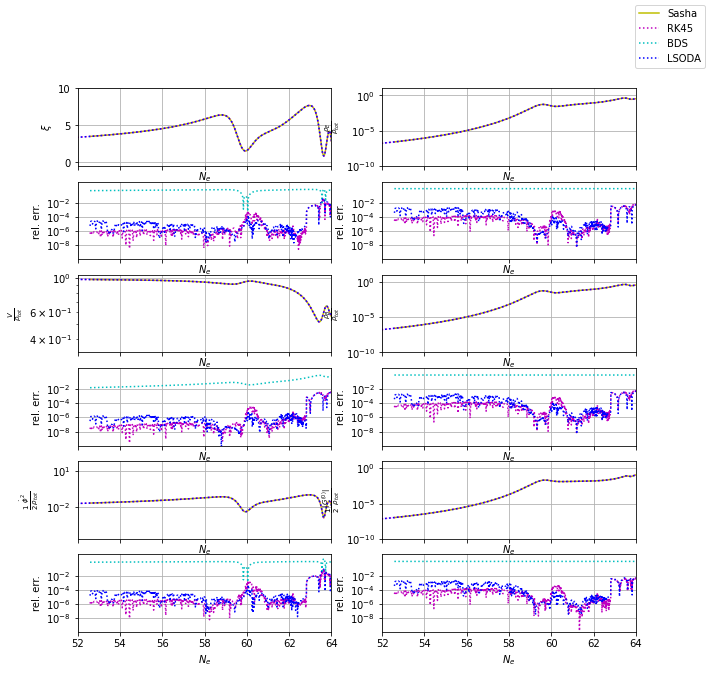

In [82]:
fig, ax = plt.subplots(6,2, figsize=(10,10), sharex=True)

r = omega/f

pot = lambda x: potential(f*x)

H = lambda xdt, x, E, B: np.sqrt( (0.5*xdt**2 + potential(f*x)/(f*omega)**2 + 0.5*(omega/f)**2*(E + B) )/3 )
xiA = GetXi(solA.y[2,:], beta, H(solA.y[2,:], solA.y[1,:], solA.y[4,:], solA.y[5,:]))
xiB = GetXi(solB.y[2,:], beta, H(solB.y[2,:], solB.y[1,:], solB.y[4,:], solB.y[5,:]))
xiC = GetXi(solC.y[2,:], beta, H(solC.y[2,:], solC.y[1,:], solC.y[4,:], solC.y[5,:]))

rhoA = 3*H(solA.y[2,:], solA.y[1,:], solA.y[4,:], solA.y[5,:])**2
rhoB = 3*H(solB.y[2,:], solB.y[1,:], solB.y[4,:], solB.y[5,:])**2
rhoC = 3*H(solC.y[2,:], solC.y[1,:], solC.y[4,:], solC.y[5,:])**2

potA = pot(solA.y[1,:])
potB = pot(solB.y[1,:])
potC = pot(solC.y[1,:])

ax[0,0].plot(data[:,0], data[:,1], "y-", label="Sasha")
PlotComp(ax[0,0], ax[1,0], solA.y[0,:], xiA, data[:,0], data[:,1], col="m:", label="RK45")
PlotComp(ax[0,0], ax[1,0], solB.y[0,:], xiB, data[:,0], data[:,1], col="c:", label="BDS")
PlotComp(ax[0,0], ax[1,0], solC.y[0,:], xiC, data[:,0], data[:,1], col="b:", label="LSODA")
#ax[0,0].set_yscale("log")
ax[0,0].set_ylabel(r"$\xi$")

ax[2,0].plot(data[:,0], data[:,2], "y-", label="Sasha")
PlotComp(ax[2,0], ax[3,0], solA.y[0,:], potA/rhoA/omega**2, data[:,0], data[:,2], col="m:", label="RK45")
PlotComp(ax[2,0], ax[3,0], solB.y[0,:], potB/rhoB/omega**2, data[:,0], data[:,2], col="c:", label="BDS")
PlotComp(ax[2,0], ax[3,0], solC.y[0,:], potC/rhoC/omega**2, data[:,0], data[:,2], col="b:", label="LSODA")
ax[2,0].set_ylabel(r"$\frac{V}{\rho_{tot}}$")
ax[2,0].set_yscale("log")

ax[4,0].plot(data[:,0], data[:,3], "y-", label="Sasha")
PlotComp(ax[4,0], ax[5,0], solA.y[0,:], solA.y[2,:]**2/(2*rhoA), data[:,0], data[:,3], col="m:", label="RK45")
PlotComp(ax[4,0], ax[5,0], solB.y[0,:], solB.y[2,:]**2/(2*rhoB), data[:,0], data[:,3], col="c:", label="BDS")
PlotComp(ax[4,0], ax[5,0], solC.y[0,:], solC.y[2,:]**2/(2*rhoC), data[:,0], data[:,3], col="b:", label="LSODA")
ax[4,0].set_ylabel(r"$\frac{1}{2}\frac{\dot{\phi}^2}{\rho_{tot}}$")
ax[4,0].set_yscale("log")

ax[0,1].plot(data[:,0], data[:,4], "y-", label="Sasha")
PlotComp(ax[0,1], ax[1,1], solA.y[0,:], r**2*solA.y[4,:]/(2*rhoA), data[:,0], data[:,4], col="m:", label="RK45")
PlotComp(ax[0,1], ax[1,1], solB.y[0,:], r**2*solB.y[4,:]/(2*rhoB), data[:,0], data[:,4], col="c:", label="BDS")
PlotComp(ax[0,1], ax[1,1], solC.y[0,:], r**2*solC.y[4,:]/(2*rhoC), data[:,0], data[:,4], col="b:", label="LSODA")
ax[0,1].set_ylabel(r"$\frac{\rho_E}{\rho_{tot}}$")
ax[0,1].set_yscale("log")

ax[2,1].plot(data[:,0], data[:,5], "y-", label="Sasha")
PlotComp(ax[2,1], ax[3,1], solA.y[0,:], r**2*solA.y[4,:]/(2*rhoA), data[:,0], data[:,5], col="m:", label="RK45")
PlotComp(ax[2,1], ax[3,1], solB.y[0,:], r**2*solB.y[4,:]/(2*rhoB), data[:,0], data[:,5], col="c:", label="BDS")
PlotComp(ax[2,1], ax[3,1], solC.y[0,:], r**2*solC.y[4,:]/(2*rhoC), data[:,0], data[:,5], col="b:", label="LSODA")
ax[2,1].set_ylabel(r"$\frac{\rho_B}{\rho_{tot}}$")
ax[2,1].set_yscale("log")

ax[4,1].plot(data[:,0], data[:,6], "y-", label="Sasha")
PlotComp(ax[4,1], ax[5,1], solA.y[0,:], r**2*abs(solA.y[6,:])/(2*rhoA), data[:,0], data[:,6], col="m:", label="RK45")
PlotComp(ax[4,1], ax[5,1], solB.y[0,:], r**2*abs(solB.y[6,:])/(2*rhoB), data[:,0], data[:,6], col="c:", label="BDS")
PlotComp(ax[4,1], ax[5,1], solC.y[0,:], r**2*abs(solC.y[6,:])/(2*rhoC), data[:,0], data[:,6], col="b:", label="LSODA")
ax[4,1].set_yscale("log")
ax[4,1].set_ylabel(r"$\frac{1}{2}\frac{|G^{(0)}|}{\rho_{tot}}$")

lines_labels = [ax[0,0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(2, 9, 2)
for i in range(3):
    ax[2*i+1,0].set_ylim(10.**(-10), 10**1)
    ax[2*i+1,0].set_yticks(10.**(-a))
    
    ax[2*i+1,1].set_ylim(10.**(-10), 10**1)
    ax[2*i+1,1].set_yticks(10.**(-a))
    
ax[0,0].set_ylim(-0.5,10)
#ax[2,0].set_ylim(-4.5e-6,1e-6)
#ax[4,0].set_ylim(-20,20)

ax[0,1].set_ylim(1e-10, 10)
ax[2,1].set_ylim(1e-10, 10)
ax[4,1].set_ylim(1e-10, 10)

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlim(52, 64)
plt.show()

In [32]:
#Set up dim-full quantities
alpha = 0
beta = 25.
Mpl = 1
M = 6.16e-6*Mpl
phi0 = -15.55*Mpl #in Pl units
dphidt0 = np.sqrt(2/3)*M*Mpl

"""file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/InitCondBilinear_b10.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values"""

E0 = 0#data[0,1]*100
B0 = 0#data[0,3]*100"""

def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2

H = np.sqrt((dphidt0**2/2 + potential(phi0) + 0.5*(E0+B0))/3 )/Mpl
#xi is indep of rescaling, so we can compute it here
xi = GetXi(dphidt0, dIdphi(phi0), H)

In [33]:
#setup dimless
omega = H

f = Mpl
ntr = 116
yini = np.zeros(ntr*3+4)
yini[0] = 0.
yini[1] = phi0/f
yini[2] = dphidt0/(f*omega)

yini[3] = np.log(2*abs(xi))


"""for i in range(ntr):
    if (omega**(4+i)>0):
        yini[4+3*i] = data[i,1]/omega**(4+i)*100
        #print(yini[4+3*i])
        yini[5+3*i] = data[i,3]/omega**(4+i)*100
        yini[6+3*i] = data[i,2]/omega**(4+i)*100"""


'for i in range(ntr):\n    if (omega**(4+i)>0):\n        yini[4+3*i] = data[i,1]/omega**(4+i)*100\n        #print(yini[4+3*i])\n        yini[5+3*i] = data[i,3]/omega**(4+i)*100\n        yini[6+3*i] = data[i,2]/omega**(4+i)*100'

In [34]:
from timer import Timer

omega = H
f = Mpl
t1 = Timer()
t2 = Timer()
t3 = Timer()

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)
print("RK45")
t1.start()
solA = solve_ivp(func, [0, 200] , yini, method="RK45", atol=1e-7, rtol=1e-6)
t1.stop()

RK45
Elapsed time: 16.1982 seconds


In [21]:
#M = 6
alpha = 0
beta = 25.
Mpl = 1
M = 6e-6*Mpl
phi0 = -15.55*Mpl #in Pl units
dphidt0 = np.sqrt(2/3)*M*Mpl

"""file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/InitCondBilinear_b10.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values"""

E0 = 0#data[0,1]*100
B0 = 0#data[0,3]*100"""

def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2

H = np.sqrt((dphidt0**2/2 + potential(phi0) + 0.5*(E0+B0))/3 )/Mpl
#xi is indep of rescaling, so we can compute it here
xi = GetXi(dphidt0, dIdphi(phi0), H)

omega = H

f = Mpl
ntr = 116
yini = np.zeros(ntr*3+4)
yini[0] = 0.
yini[1] = phi0/f
yini[2] = dphidt0/(f*omega)

yini[3] = np.log(2*abs(xi))

from timer import Timer

omega = H
f = Mpl
t1 = Timer()
t2 = Timer()
t3 = Timer()

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)
print("RK45")
t1.start()
solB = solve_ivp(func, [0, 200] , yini, method="RK45", atol=1e-7, rtol=1e-6)
t1.stop()

RK45
Elapsed time: 15.1816 seconds


In [22]:
from scipy.signal import savgol_filter
import subprocess
import os
from os.path import dirname

dir         = os.getcwd()

dir_dropbox = '/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/AxionGradientExpansion_comparison/'

In [23]:
try:
    print(dir_dropbox)
    res_cern = np.loadtxt( dir_dropbox + 'data_cern/beta_25/background.dat', skiprows= 2)
    t_cern       = res_cern.T[0]
    Ne_cern      = res_cern.T[1]
    phi_cern     = res_cern.T[2]
    h_cern       = res_cern.T[3]
    xi_cern      = res_cern.T[4]
    pe0_cern     = res_cern.T[5]
    pb0_cern     = res_cern.T[6]
    peb0_cern    = res_cern.T[7]
except:
    print(">> FAIL <<")
    pass

try:
    res_munster = np.loadtxt( dir_dropbox + 'data_munster/beta_25_M/background_25_M.dat', skiprows= 2)
    t_munster       = res_munster.T[0]
    Ne_munster      = res_munster.T[1]
    phi_munster     = res_munster.T[2]
    h_munster       = res_munster.T[3]
    xi_munster      = res_munster.T[4]
    pe0_munster     = res_munster.T[5]
    pb0_munster     = res_munster.T[6]
    peb0_munster    = res_munster.T[7]
except:
    print(">> FAIL <<")
    pass

/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/AxionGradientExpansion_comparison/


In [24]:
H2 = lambda xdt, x, E, B: np.sqrt( (0.5*xdt**2 + potential(f**2*x)/(f*omega)**2 + 0.5*(omega/f)**2*(E + B) )/3 )
xiA = GetXi(solA.y[2,:], beta, H2(solA.y[2,:], solA.y[1,:], solA.y[4,:], solA.y[5,:]))
xiB = GetXi(solB.y[2,:], beta, H2(solB.y[2,:], solB.y[1,:], solB.y[4,:], solB.y[5,:]))
#xiC = GetXi(solC.y[2,:], beta, H2(solC.y[2,:], solC.y[1,:], solC.y[4,:], solC.y[5,:]))

stp = max(solA.y[0,:])

/tmp/ipykernel_7553/1167182989.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


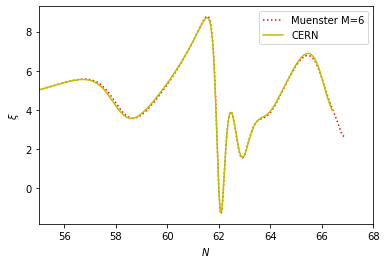

In [26]:
#spl = np.interp(Ne_cern, solB.y[0,:], xiB)
#plt.plot(Ne_cern, spl, "r-", label="fit")
#plt.plot(solA.y[0,:], abs(xiA), "m:", label="RK45")
#plt.plot(solB.y[0,:], abs(xiB), "c:", label="BDS")

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
#plt.plot(solA.y[0,:], xiA, "b:", label="Muenster M=6.16")
plt.plot(solB.y[0,:], xiB, "r:", label="Muenster M=6")
plt.plot(Ne_cern, xi_cern, "y-", label="CERN")
#plt.plot(Ne_munster, xi_munster, "g-", label="Muenster Old")
plt.legend(loc=0)
#plt.yscale("log")
plt.ylabel(r"$\xi$")
plt.xlabel(r"$N$")
plt.xlim(55, 68)
#plt.savefig("Beta25Comparision.png", dpi=300)
fig.show()

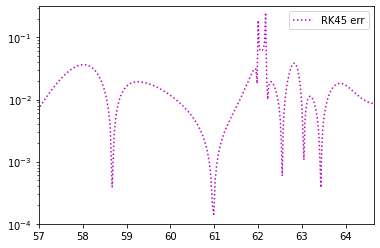

In [29]:
spl = CubicSpline(solB.y[0,:], xiB)
plt.plot(Ne_cern, abs(spl(Ne_cern)/xi_cern-1), "m:", label="RK45 err")
"""spl = np.interp(Ne_cern, solB.y[0,:], xiB)
plt.plot(Ne_cern, abs(-spl/xi_cern-1), "c:", label="BDS err")
spl = np.interp(Ne_cern, solC.y[0,:], xiC)
plt.plot(Ne_cern, abs(-spl/xi_cern-1), "b:", label="LSODA err")"""
plt.yscale("log")
"""spl = np.interp(data[:,0], solB.y[0,:], xiB)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], xiC)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "b:", label="exact err")
"""
#plt.plot(Ne_cern, abs(xi_cern), "k-", label="CERN")
plt.legend(loc=0)
plt.xlim(57, min(stp, max(Ne_cern)))
plt.ylim(10**(-4), 10**(-1/2))
plt.show()

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
#plt.plot(solA.y[0,:], xiA, "b:", label="Muenster M=6.16")
plt.plot(solB.y[0,:], xiB, "r:", label="Muenster M=6")
plt.plot(Ne_cern, xi_cern, "y-", label="CERN")
#plt.plot(Ne_munster, xi_munster, "g-", label="Muenster Old")
plt.legend(loc=0)
#plt.yscale("log")
plt.ylabel(r"$\xi$")
plt.xlabel(r"$N$")
plt.xlim(55, 68)
#plt.savefig("Beta25Comparision.png", dpi=300)
fig.show()

/tmp/ipykernel_4408/4205943630.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


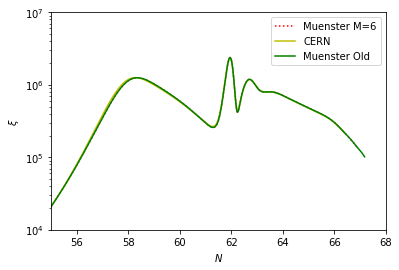

In [80]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
#plt.plot(solA.y[0,:], 0.5*solA.y[0,:]*omega**4, "b:", label="Muenster M=6.16")
plt.plot(solB.y[0,:], solB.y[6,:], "r:", label="Muenster M=6")
plt.plot(Ne_cern, peb0_cern, "y-", label="CERN")
plt.plot(Ne_munster, peb0_munster, "g-", label="Muenster Old")
plt.legend(loc=0)
#plt.yscale("log")
plt.ylabel(r"$\xi$")
plt.xlabel(r"$N$")
plt.yscale("log")
plt.xlim(55, 68)
plt.ylim(10**4, 10**7)
#plt.savefig("Beta25Comparision.png", dpi=300)
fig.show()

In [72]:
print(t_munster[0], Ne_munster[0], phi_munster[0], h_munster[0], pe0_munster[0], pb0_munster[0], peb0_munster[0])
H2B = H2(solB.y[2,:], solB.y[1,:], solB.y[4,:], solB.y[5,:])
print(solB.t[0], solB.y[0,93], solB.y[1,93], H2B[93],
      solB.y[4,93], solB.y[5,93], solB.y[6,93])

0.4 0.39934067425694303 -15.498653374378257 0.9967044047210838 1.1027046354650603 1.9634905593724568 0.4707054157913268
0.0 0.4010504629168784 -15.498433253136254 0.9966902824904345 1.105140175946431 1.9681979199290207 0.4725474951115164


/tmp/ipykernel_4408/1248086643.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 0.5)
/tmp/ipykernel_4408/1248086643.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


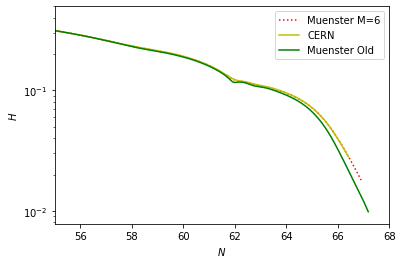

In [84]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
#plt.plot(solA.y[0,:], 0.5*solA.y[0,:]*omega**4, "b:", label="Muenster M=6.16")
plt.plot(solB.y[0,:], H2B, "r:", label="Muenster M=6")
plt.plot(Ne_cern, h_cern, "y-", label="CERN")
plt.plot(Ne_munster, h_munster, "g-", label="Muenster Old")
plt.legend(loc=0)
#plt.yscale("log")
plt.ylabel(r"$H$")
plt.xlabel(r"$N$")
plt.yscale("log")
plt.xlim(55, 68)
plt.ylim(0, 0.5)
#plt.savefig("Beta25Comparision.png", dpi=300)
fig.show()

/tmp/ipykernel_4408/4141044629.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


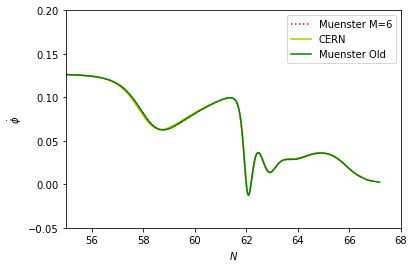

In [89]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
#plt.plot(solA.y[0,:], 0.5*solA.y[0,:]*omega**4, "b:", label="Muenster M=6.16")
plt.plot(solB.y[0,:], solB.y[2,:], "r:", label="Muenster M=6")
plt.plot(Ne_cern, 2*h_cern*xi_cern/25., "y-", label="CERN")
plt.plot(Ne_munster, 2*h_munster*xi_munster/25., "g-", label="Muenster Old")
plt.legend(loc=0)
plt.ylabel(r"$\dot{\phi}$")
plt.xlabel(r"$N$")
plt.xlim(55, 68)
plt.ylim(-0.05, 0.2)
#plt.savefig("Beta25Comparision.png", dpi=300)
fig.show()

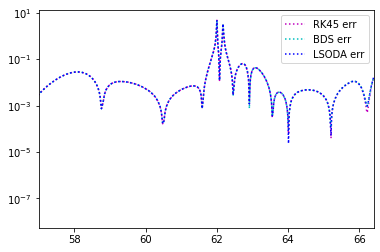

In [42]:
spl = np.interp(Ne_cern, solA.y[0,:], xiA)
plt.plot(Ne_cern, abs(spl/xi_cern-1), "m:", label="RK45 err")
spl = np.interp(Ne_cern, solB.y[0,:], xiB)
plt.plot(Ne_cern, abs(spl/xi_cern-1), "c:", label="BDS err")
spl = np.interp(Ne_cern, solC.y[0,:], xiC)
plt.plot(Ne_cern, abs(spl/xi_cern-1), "b:", label="LSODA err")
plt.yscale("log")
"""spl = np.interp(data[:,0], solB.y[0,:], xiB)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], xiC)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "b:", label="exact err")
"""
#plt.plot(Ne_cern, abs(xi_cern), "k-", label="CERN")
plt.legend(loc=0)
plt.xlim(57, min(stp, max(Ne_cern)))
plt.show()

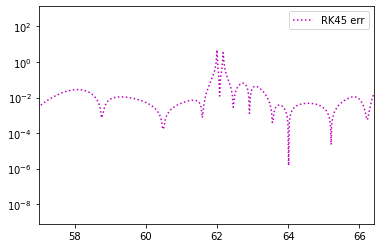

In [43]:
spl = CubicSpline(solA.y[0,:], xiA)
plt.plot(Ne_cern, abs(spl(Ne_cern)/xi_cern-1), "m:", label="RK45 err")
"""spl = np.interp(Ne_cern, solB.y[0,:], xiB)
plt.plot(Ne_cern, abs(-spl/xi_cern-1), "c:", label="BDS err")
spl = np.interp(Ne_cern, solC.y[0,:], xiC)
plt.plot(Ne_cern, abs(-spl/xi_cern-1), "b:", label="LSODA err")"""
plt.yscale("log")
"""spl = np.interp(data[:,0], solB.y[0,:], xiB)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "c:", label="exact err")
spl = np.interp(data[:,0], solC.y[0,:], xiC)
ax[5,0].plot(data[:,0], abs(spl/xidat-1), "b:", label="exact err")
"""
#plt.plot(Ne_cern, abs(xi_cern), "k-", label="CERN")
plt.legend(loc=0)
plt.xlim(57, min(stp, max(Ne_cern)))
plt.show()

In [46]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Data_b25.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)

(201, 6)


/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i

/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:

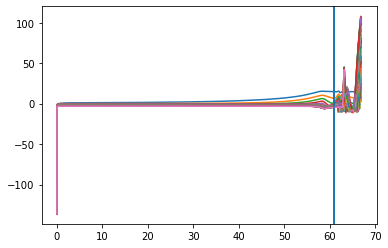

/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
/tmp/ipykernel_4887/3439772407.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(solA.y[0,:], np.log((so

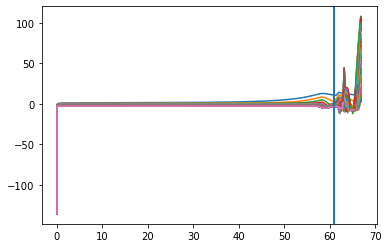

In [48]:
for i in range(int((ntr-1)/2)):
    plt.plot(solA.y[0,:], np.log((solA.y[4+6*i,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
    plt.axvline(x=61)
plt.show()
for i in range(int((ntr-1)/2)):
    plt.plot(solA.y[0,:], np.log((solA.y[4+6*i+1,:])) +2*i*solA.y[0,:] - 2*i*solA.y[3,:] )
    plt.axvline(x=61)
plt.show()


In [49]:
"""kh = np.exp(solA.y[3,:])
a = np.exp(solA.y[0,:])
G =  solA.y[-4,:]/solA.y[-10,:]*a**2/kh**2
B = solA.y[-5,:]/solA.y[-11,:]*a**2/kh**2
E = solA.y[-6,:]/solA.y[-12,:]*a**2/kh**2

plt.plot(solA.y[0,:], kh/kh[-1], "k:", label=r"$\frac{k_h(N)}{k_h(N_{end})}$")
plt.plot(solA.y[0,:], abs(G), "r:",
         label=r"$|\frac{G^{114}a^2}{G^{112}k_h^2}|$")
plt.plot(solA.y[0,:], abs(B), "g:",
         label=r"$|\frac{B^{114}a^2}{G^{112}k_h^2}|$")
plt.plot(solA.y[0,:], abs(E), "b:",
         label=r"$|\frac{E^{114}a^2}{G^{112}k_h^2}|$")
plt.legend(loc=0, ncol=2)
plt.yscale("log")
plt.ylabel("deviation")
plt.xlabel(r"$N_e$")
plt.ylim(0.0001)
plt.xlim(60-2, stp)"""

'kh = np.exp(solA.y[3,:])\na = np.exp(solA.y[0,:])\nG =  solA.y[-4,:]/solA.y[-10,:]*a**2/kh**2\nB = solA.y[-5,:]/solA.y[-11,:]*a**2/kh**2\nE = solA.y[-6,:]/solA.y[-12,:]*a**2/kh**2\n\nplt.plot(solA.y[0,:], kh/kh[-1], "k:", label=r"$\x0crac{k_h(N)}{k_h(N_{end})}$")\nplt.plot(solA.y[0,:], abs(G), "r:",\n         label=r"$|\x0crac{G^{114}a^2}{G^{112}k_h^2}|$")\nplt.plot(solA.y[0,:], abs(B), "g:",\n         label=r"$|\x0crac{B^{114}a^2}{G^{112}k_h^2}|$")\nplt.plot(solA.y[0,:], abs(E), "b:",\n         label=r"$|\x0crac{E^{114}a^2}{G^{112}k_h^2}|$")\nplt.legend(loc=0, ncol=2)\nplt.yscale("log")\nplt.ylabel("deviation")\nplt.xlabel(r"$N_e$")\nplt.ylim(0.0001)\nplt.xlim(60-2, stp)'

In [ ]:
omega = H
f = Mpl
func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)

solA = solve_ivp(func, [0, 125] , yini, method="LSODA", atol=1e-7, rtol=1e-6)

func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=False)

solB = solve_ivp(func, [0, 125] , yini, method="LSODA", atol=1e-7, rtol=1e-6)

In [ ]:
fig, ax = plt.subplots(6,2, figsize=(10,10), sharex=True)

#ax[0,0].plot(sol2.y[0,:], sol2.y[1,:], "g:", label="chaotic inflation")

#ax[2,0].plot(sol2.y[0,:], sol2.y[2,:], "g:", label="chaotic inflation")

#ax[4,0].plot(sol2.y[0,:], 1/sol2.y[1,:]**2, "g:", label="chaotic inflation")



ax[0,0].plot(data[:,0], data[:,1], "y-", label="Sasha")

ax[2,0].plot(data[:,0], data[:,2], "y-", label="Sasha")

ax[4,0].plot(data[:,0], 1/data[:,1]**2, "y-", label="Sasha")

ax[0,1].plot(data[:,0], 0.5*data[:,3], "y-", label="Sasha")

ax[2,1].plot(data[:,0], 0.5*data[:,4], "y-", label="Sasha")

ax[4,1].plot(data[:,0], 0.5*abs(data[:,5]), "y-", label="Sasha")


col = "m:"#, "g:", "c:", "m:"]
    
ax[0,0].plot(solA.y[0,:], solA.y[1,:]*f, col, label="approx W")
ax[2,0].plot(solA.y[0,:], solA.y[2,:]*f*omega, col, label="approx")
ax[4,0].plot(solA.y[0,:], 1/(solA.y[1,:]*f)**2, col, label="approx")
    
ax[0,1].plot(solA.y[0,:], 0.5*solA.y[4,:]*omega**4, col, label="approx")
ax[2,1].plot(solA.y[0,:], 0.5*solA.y[5,:]*omega**4, col, label="approx")
ax[4,1].plot(solA.y[0,:], abs(0.5*solA.y[6,:])*omega**4, col, label="approx")

print("plotted")

col= "c:"
    
ax[0,0].plot(solB.y[0,:], solB.y[1,:]*f, col, label="exact W ")
ax[2,0].plot(solB.y[0,:], solB.y[2,:]*f*omega, col, label="exact")
ax[4,0].plot(solB.y[0,:], 1/(solB.y[1,:]*f)**2, col, label="exact")
    
ax[0,1].plot(solB.y[0,:], 0.5*solB.y[4,:]*omega**4, col, label="exact")
ax[2,1].plot(solB.y[0,:], 0.5*solB.y[5,:]*omega**4, col, label="exact")
ax[4,1].plot(solB.y[0,:], abs(0.5*solB.y[6,:]*omega**4), col, label="exact")


ax[0,1].set_title("Electric field energy density")
ax[0,1].set_ylabel(r"$\rho_E$")
ax[0,1].set_xlabel(r"$N_e$")
ax[0,1].set_yscale("log")
#ax[0,1].legend(loc=0)

ax[2,1].set_title("Magnetic field energy density")
ax[2,1].set_ylabel(r"$\rho_B$")
ax[2,1].set_xlabel(r"$N_e$")
ax[2,1].set_yscale("log")
#ax[2,1].legend(loc=0)

ax[4,1].set_title("Mixed term")
ax[4,1].set_ylabel(r"$\frac{1}{2}\langle E \cdot B \rangle$")
ax[4,1].set_xlabel(r"$N_e$")
ax[4,1].set_yscale("log")
#ax[4,1].legend(loc=0)

ax[2,0].set_title("field velocity")
ax[2,0].set_ylabel(r"$\phi'$")
ax[2,0].set_xlabel(r"$N_e$")
#ax[2,0].legend(loc=0)

ax[0,0].set_title("field amplitude")
ax[0,0].set_ylabel(r"$\phi$")
ax[0,0].set_xlabel(r"$N_e$")
#ax[0,0].legend(loc=0)

ax[4,0].set_title("slow roll parameter")
ax[4,0].set_ylabel(r"$\epsilon$")
ax[4,0].set_xlabel(r"$N_e$")
#ax[4,0].legend(loc=0)



spl = CubicSpline(solA.y[0,:], solA.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl(data[:,0])/data[:,1]-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl(data[:,0])/data[:,1]-1), "c:", label="exact err")

spl = CubicSpline(data[:,0], data[:,1])
ax[1,0].plot(solB.y[0,:], abs(spl(solB.y[0,:])/(solB.y[1,:]*f)-1), "y:", label="opp. int. apx")
#ax[1,0].plot(solB.y[0,:], abs(solB.y[1,:]*f/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")

ax[1,0].set_ylabel("rel. err.")
ax[1,0].set_xlabel(r"$N_e$")
ax[1,0].set_yscale("log")
#ax[1,0].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl(data[:,0])/data[:,2]-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl(data[:,0])/data[:,2]-1), "c:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,2])
ax[3,0].plot(solB.y[0,:], abs(spl(solB.y[0,:])/(solB.y[2,:]*f*omega)-1), "y:", label="opp. int. apx")
#ax[3,0].plot(solB.y[0,:], abs(solB.y[2,:]*f*omega/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")"""

ax[3,0].set_ylabel("rel. err.")
ax[3,0].set_xlabel(r"$N_e$")
ax[3,0].set_yscale("log")

spl = CubicSpline(solA.y[0,:], 1/(solA.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl(data[:,0])*data[:,1]**2-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], 1/(solB.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl(data[:,0])*data[:,1]**2-1), "c:", label="exact err")

"""spl = CubicSpline(data[:,0], 1/data[:,1]**2)
ax[5,0].plot(solB.y[0,:], abs(spl(solB.y[0,:])*(solB.y[1,:]*f*omega)**2-1), "y:", label="opp. int. apx")
#ax[5,0].plot(solA.y[0,:], abs(1/(spl(solA.y[0,:])*solA.y[1,:]**2)-1), "b:", label="opp. int. apx")
#ax[5,0].plot(solB.y[0,:], abs(1/(spl(solB.y[0,:])*solB.y[1,:]**2)-1), "r:", label="opp. int. ex")"""

ax[5,0].set_ylabel("rel. err.")
ax[5,0].set_xlabel(r"$N_e$")
ax[5,0].set_yscale("log")
#ax[5,0].legend(loc=0)

spl = CubicSpline(solA.y[0,:], solA.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl(data[:,0])/data[:,3]-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl(data[:,0])/data[:,3]-1), "c:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,3])
ax[1,1].plot(solB.y[0,:], abs(spl(solB.y[0,:])/(solB.y[4,:]*omega**4)-1), "y:", label="opp. int. apx")
#ax[1,1].plot(solA.y[0,:], abs(solA.y[4,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
#ax[1,1].plot(solB.y[0,:], abs(solB.y[4,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")
"""
ax[1,1].set_ylabel("rel. err.")
ax[1,1].set_xlabel(r"$N_e$")
ax[1,1].set_yscale("log")
#ax[1,1].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl(data[:,0])/data[:,4]-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl(data[:,0])/data[:,4]-1), "c:", label="exact err")

"""
spl = CubicSpline(data[:,0], data[:,4])
ax[3,1].plot(solB.y[0,:], abs(spl(solB.y[0,:])/(solB.y[5,:]*omega**4)-1), "y:", label="opp. int. apx")
#ax[3,1].plot(solA.y[0,:], abs(solA.y[5,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
#ax[3,1].plot(solB.y[0,:], abs(solB.y[5,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")"""

ax[3,1].set_ylabel("rel. err.")
ax[3,1].set_xlabel(r"$N_e$")
ax[3,1].set_yscale("log")
#ax[3,1].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl(data[:,0])/data[:,5]-1), "m:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl(data[:,0])/data[:,5]-1), "c:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,5])
ax[3,1].plot(solB.y[0,:], abs(spl(solB.y[0,:])/(solB.y[6,:]*omega**4)-1), "y:", label="opp. int. apx")
#ax[5,1].plot(solA.y[0,:], abs(solA.y[6,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
#ax[5,1].plot(solB.y[0,:], abs(solB.y[6,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")"""

ax[5,1].set_ylabel("rel. err.")
ax[5,1].set_xlabel(r"$N_e$")
ax[5,1].set_yscale("log")
#ax[5,1].legend(loc=0)
lines_labels = [ax[0,0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

#for a in fig.axes:
 #   a.set_xlim(0.5,65)
a = np.arange(2, 9, 2)
print(a)
ax[1, 0].set_yticks(10.**(-a))
ax[3, 0].set_yticks(10.**(-a))
ax[5, 0].set_yticks(10.**(-a))
ax[1, 1].set_yticks(10.**(-a))
ax[3, 1].set_yticks(10.**(-a))
ax[5, 1].set_yticks(10.**(-a))

ax[1, 0].set_ylim(10.**(-10), 10**1)
ax[3, 0].set_ylim(10.**(-10), 10**1)
ax[5, 0].set_ylim(10.**(-10), 10**1)
ax[1, 1].set_ylim(10.**(-10), 10**1)
ax[3, 1].set_ylim(10.**(-10), 10**1)
ax[5, 1].set_ylim(10.**(-10), 10**1)
for ax in fig.axes:
    ax.grid(True)
plt.show()

# Anber Sorbo Setup

In [15]:
def EBGnIntegrand(k, xi, a, n):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*xi)

    Whitt1Plus = whitw(-xi*(1j), 1/2, -2j*k/a)
    Whitt2Plus = whitw(1-xi*(1j), 1/2, -2j*k/a)
    
    Whitt1Minus = whitw(xi*(1j), 1/2, -2j*k/a)
    Whitt2Minus = whitw(1+xi*(1j), 1/2, -2j*k/a)
    
    EtermPlus = abs((1j*k/a - 1j*xi) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/a + 1j*xi) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    #ErotnE = int(Edk) 
    E = k**(1+n) * a**(-n-2) / (4*np.pi**2) * (expterm[0]*EtermPlus + (-1)**n * expterm[1]*EtermMinus)
    
    #BrotnB = int(Bdk) 
    B = k**(3+n) * a**(-n-4) / (4*np.pi**2) * (expterm[0]*BtermPlus + (-1)**n * expterm[1]*BtermMinus)
    
    #-ErotnB = int(Gdk)
    G =  k**(2+n) * a**(-n-3) / (4*np.pi**2 ) * (expterm[0]*GtermPlus - (-1)**n * expterm[1]*GtermMinus)
    return E, B, G

def ComputeEBGn(xi, a, n):
    
    E = lambda k: EBGnIntegrand(k, xi, a, n)[0]
    B = lambda k: EBGnIntegrand(k, xi, a, n)[1]
    G = lambda k: EBGnIntegrand(k, xi, a, n)[2]
    
    kh = 2*a*abs(xi)
    
    En = quad(E, 0, kh)[0]
    Bn = quad(B, 0, kh)[0]
    Gn = quad(G, 0, kh)[0]
    
    return En, Bn, Gn

def ConstPotentialSlope(xi, G, H, Iterm):
    return -(2*(3-alpha)*H**2*xi/Iterm + Iterm*G)

def SetupConstH(xi, beta, a, ntr, file=None):
    Fvec = np.zeros(3*ntr)
    
    #H=1
    Mpl = 1.0
    H = 2e-7*(beta/100)**(-1/2)*np.exp(-2.85*(xi-7))*Mpl
    #Mpl = 0.5e7*(beta/100)**(1/2)*np.exp(2.85*(xi-7))*H
    
    ratio = (H/Mpl)
    print(ratio)
    
    if(file==None):
        F = np.zeros((ntr, 3))
        for i in range(ntr):
            #unitless, powers of H need to be restored
            F[i,:] = ComputeEBGn(xi, a, i)
            print(str(int(3*(i+1))) + " out of " + str(int(3*ntr)) + " bilinear terms computed")

        DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
        output_df = pd.DataFrame(DataDic)  
        filename = "ConstH_xi" + str(xi) + "_Initialiser.dat"
        output_df.to_csv(filename)
                
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        if (np.shape(data)[0]<ntr):
            nprog = np.shape(data)[0]
            print("need to compute "+str(int(3*(ntr-nprog))) + " more bilinear terms")
            F = np.zeros((ntr, 3))
            F[:nprog,0] = data[:,1].T
            F[:nprog,1] = data[:,2].T
            F[:nprog,2] = data[:,3].T
            
            for i in range(nprog, ntr):
                F[i,:] = ComputeEBGn(xi, a, i)
                print(str(int(3*(i+1-nprog))) + " out of " + str(int(3*(ntr-nprog))) + " bilinear terms computed")

            DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
            output_df = pd.DataFrame(DataDic)  
            output_df.to_csv(file)
        else:
            F = np.array([data[:ntr,1], data[:ntr,2], data[:ntr,3]]).T
        
    Fvec = F.reshape(3*ntr)
    
    lnkh = np.log(2*a*abs(xi))
    
    """g = ConstPotentialSlope(xi, F[0,2]*H**4, H, beta/Mpl)
    h = (H**2*Mpl**2) * (3 - 2*xi**2/beta**2) - 0.5 * (F[0,0]+ F[0,1]) * H**4
    
    phi0 = 2*h/g
    print(phi0)
    m2 = g**2/(2*h)
    #units restored, needed for GEF wrapper
    print(F[0,2])"""
    Vprime = ConstPotentialSlope(xi, F[0,2]*H**4, H, beta/Mpl)
    """print("G")
    print("real:",F[0,2])
    print("approx:",2.4e-4*np.exp(2*np.pi*xi)*(1/xi)**4)
    print("rel:", abs(1-F[0,2]/(2.4e-4*np.exp(2*np.pi*xi)*(1/xi)**4)))
    
    print("E")
    print("real:",(F[0,0]+F[0,1])/2)
    print("approx:",1.4e-4*np.exp(2*np.pi*xi)*(1/xi)**3)
    print("rel:", abs(1-(F[0,0]+F[0,1])/2/(1.4e-4*np.exp(2*np.pi*xi)*(1/xi)**3)))"""
    V0 = (H*Mpl)**2 * (3 - 2*xi**2/beta**2) - 0.5 * (F[0,0]+ F[0,1]) * H**4
    
    dIdphi = beta/Mpl
    #print(F[0,:]*H**4)
    
    f = Mpl
    omega = H
    
    #return Fvec, lnkh, m2, phi0, dIdphi, f, omega
    return Fvec, lnkh, V0, Vprime, dIdphi, f, omega
    

# Full GEF Anber Sorbo

In [49]:
alpha = 0
ntr = 140
xi = 7
beta = 10**(2.5)
phi0 = 0
#F, lnkh, m2, phi0, dIdphi, f, omega = SetupConstH(xi, beta, 1., ntr, file="ConstH_xi_7_Initialiser.dat")
F, lnkh, V0, Vprime, dIdphi, f, omega = SetupConstH(xi, beta, 1., ntr, file="ConstH_xi_7_Initialiser.dat")
#dimless velocity
Mpl = f
dphidt0 = 2*xi/beta

def potential(phi):
    V = Vprime*phi + V0
    return abs(V)

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    V = Vprime*phi + V0
    #return Vprime
    if V<0:
        return -Vprime
    else:
        return Vprime

#print(f)
#print(omega)
print(Vprime, V0)
#print(f/2*abs(Vprime)**2/V0**2)
zini = np.zeros(ntr*3+4)
zini[0] = 0.
zini[1] = phi0/f
zini[2] = dphidt0
zini[3] = lnkh
zini[4:] = F

1.1246826503806981e-07
-7.310615492204428e-14 3.7144393124253725e-14


In [50]:
func = lambda t, x: fullGEF(t, x, f=f, omega=omega, approx=True)

sol = solve_ivp(func, [0,100] , zini, method="RK45")

/tmp/ipykernel_10474/3428666590.py:65: RuntimeWarning: overflow encountered in double_scalars
  scale = (kh/a)**(i+4)
/tmp/ipykernel_10474/3428666590.py:66: RuntimeWarning: invalid value encountered in double_scalars
  bdrF[i, 0] = prefac*scale*(EtermPlus + (-1)**i * EtermMinus)
/tmp/ipykernel_10474/3428666590.py:67: RuntimeWarning: invalid value encountered in double_scalars
  bdrF[i, 1] = prefac*scale*(BtermPlus + (-1)**i * BtermMinus)
/tmp/ipykernel_10474/3428666590.py:68: RuntimeWarning: invalid value encountered in double_scalars
  bdrF[i, 2] = prefac*scale*(GtermPlus - (-1)**i * GtermMinus)
/tmp/ipykernel_10474/2646801261.py:10: RuntimeWarning: overflow encountered in double_scalars
  - 2*kh**2 * a**(alpha-2)*Fmin1[2] + 2*Iterm*F[2]*dphidt)
/tmp/ipykernel_10474/2646801261.py:11: RuntimeWarning: overflow encountered in double_scalars
  dFdt[1] = bdrF[1] - (4+ntr)*H*F[1] + 2*kh**2 * a**(alpha-2)*Fmin1[2]
/tmp/ipykernel_10474/2646801261.py:13: RuntimeWarning: overflow encountered in

Hsq: -1.0844854677415968e-03
loga: 13.616699002647136
t 30.207533233054153


/tmp/ipykernel_10474/3100720140.py:61: RuntimeWarning: invalid value encountered in sqrt
  dydt[0] = np.sqrt(Hsq)
/tmp/ipykernel_10474/3100720140.py:65: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(Hsq)


Hsq: -3.2861516568016428e-03
loga: 13.617489460481568
t 30.220373085760016
Hsq: -7.533102193622148e-03
loga: 13.617620728468484
t 30.222286472931124
Hsq: -1.616150549361679e-03
loga: 13.61771612669297
t 30.224024161596468
Hsq: -3.519160797968203e-05
loga: 13.617726828040317
t 30.224258590268857
Hsq: -1.3916850390393795e-04
loga: 13.617940650568695
t 30.228069189058754
Hsq: -2.6874757808862033e-03
loga: 13.618029779911916
t 30.229316737489473
Hsq: -3.172435582123697e-03
loga: 13.618126187280966
t 30.231228374915357
Hsq: -2.1363520700699388e-03
loga: 13.618211606065394
t 30.232680936878126
Hsq: -5.54986583086645e-03
loga: 13.618294474320223
t 30.234123924200773
Hsq: -1.4037971161330442e-03
loga: 13.618370484102263
t 30.23549402007034
Hsq: -1.6892144442396534e-04
loga: 13.618443326421147
t 30.236763439149367
Hsq: -3.2510355865567747e-04
loga: 13.61844572668781
t 30.236984562387427
Hsq: -7.99538744832207e-04
loga: 13.618504800605644
t 30.237843110725986
Hsq: -2.1942709682214873e-03
loga: 1

Hsq: -4.530571751738809e-04
loga: 13.619137763473924
t 30.259775374212527
Hsq: -1.0793073861564695e-05
loga: 13.619135888773942
t 30.25975915819191
Hsq: -2.174092137157991e-04
loga: 13.61913580910927
t 30.259818906288547
Hsq: -4.904395475219217e-04
loga: 13.619135009939546
t 30.259877696220972
Hsq: -9.456454076114396e-04
loga: 13.619133317456074
t 30.259946455347556
Hsq: -1.413366235090733e-03
loga: 13.619130524987042
t 30.260024690357273
Hsq: -1.3530212476059432e-03
loga: 13.619126472512969
t 30.260114312268467
Hsq: -3.426641715895591e-05
loga: 13.619139691530629
t 30.260113058352246
Hsq: -1.6642199742957867e-04
loga: 13.619141593042084
t 30.26035046226854
Hsq: -7.164942363195592e-05
loga: 13.61914155645242
t 30.260431534089903
Hsq: -1.2562123594086303e-03
loga: 13.619140863257021
t 30.260465635177624
Hsq: -3.328550466599945e-03
loga: 13.619136254852382
t 30.260557652489382
Hsq: -3.739662304181085e-03
loga: 13.619130602817384
t 30.260647697341582
Hsq: -2.1087077071520743e-03
loga: 13.

Hsq: -1.275249540498002e-04
loga: 13.619206952926206
t 30.26900814678408
Hsq: -7.18190934107174e-05
loga: 13.619205791082834
t 30.268988978491656
Hsq: -4.604043301828659e-04
loga: 13.61920537787305
t 30.26903581107516
Hsq: -9.291827416506107e-04
loga: 13.619204285979274
t 30.269081279062267
Hsq: -1.5415851946723427e-03
loga: 13.619202414297543
t 30.26913291130443
Hsq: -3.101556015641792e-03
loga: 13.619197178342032
t 30.26920568150821
Hsq: -2.9683586953473347e-05
loga: 13.619208597135833
t 30.269201408318725
Hsq: -4.8363079019811864e-05
loga: 13.61920876725636
t 30.269275195586943
Hsq: -2.081836506798128e-04
loga: 13.619210429279036
t 30.269448159848537
Hsq: -1.0826290871007171e-03
loga: 13.619210185372363
t 30.269470521396453
Hsq: -2.787478576025816e-03
loga: 13.619206972227836
t 30.269526052655113
Hsq: -3.2785566476379495e-03
loga: 13.61920375642979
t 30.269581227663082
Hsq: -4.659705017080641e-03
loga: 13.619196887522337
t 30.269659087517777
Hsq: -6.784361366716368e-05
loga: 13.6192

t 30.27457827879218
Hsq: -1.3447168276413742e-03
loga: 13.619245925929905
t 30.27461524129481
Hsq: -2.3288837112229047e-03
loga: 13.619243721315486
t 30.27466098412635
Hsq: -3.144823796391261e-03
loga: 13.619239746226928
t 30.274715914126418
Hsq: -7.13430870238225e-05
loga: 13.619250223906437
t 30.27471516653762
Hsq: -3.2280743524709665e-05
loga: 13.61925006777562
t 30.27477162724957
Hsq: -4.519227319883164e-04
loga: 13.619251917155857
t 30.27492065050816
Hsq: -1.748344826207748e-03
loga: 13.619251287863676
t 30.2749369873912
Hsq: -3.812973084944488e-03
loga: 13.619247867636654
t 30.27498293650152
Hsq: -5.825005020538841e-03
loga: 13.619243528177513
t 30.275037879644692
Hsq: -6.8999940676204895e-06
loga: 13.619250530881187
t 30.274958300068512
Hsq: -1.4173115579054624e-04
loga: 13.61925011276013
t 30.274986721345712
Hsq: -2.1111471394855003e-03
loga: 13.61924521397158
t 30.27504811130447
Hsq: -1.4553143297000904e-05
loga: 13.619252662718008
t 30.275050579061052
Hsq: -6.002280823226337e

Hsq: -6.213050727784513e-03
loga: 13.619278837734065
t 30.27926053805094
Hsq: -2.0599608816568533e-05
loga: 13.61928252680687
t 30.279192842835943
Hsq: -1.870809978057244e-04
loga: 13.619282246683865
t 30.279217019698457
Hsq: -2.8795527432229594e-03
loga: 13.619278831826167
t 30.279269241721472
Hsq: -8.363148075676757e-03
loga: 13.619270530236367
t 30.27933440323156
Hsq: -1.96811274165339e-05
loga: 13.61928244580698
t 30.279256643971042
Hsq: -1.8191068291882026e-04
loga: 13.61928178064566
t 30.279284415135507
Hsq: -1.9234241052151744e-03
loga: 13.619273995976222
t 30.27934440085076
Hsq: -1.267719788642883e-04
loga: 13.619284766753628
t 30.279343860147367
Hsq: -1.204251670285076e-03
loga: 13.6192864953672
t 30.27948105362872
Hsq: -5.13003250966255e-04
loga: 13.619286333753832
t 30.279488465684015
Hsq: -3.5291159152372087e-03
loga: 13.619283896834045
t 30.279528700060638
Hsq: -5.570124221919668e-06
loga: 13.619284819612243
t 30.279485869061876
Hsq: -1.383666336484968e-04
loga: 13.6192846

Hsq: -2.955238687255816e-03
loga: 13.619299600618897
t 30.282474423811067
Hsq: -1.2767821888499026e-04
loga: 13.619308195828337
t 30.282476369716104
Hsq: -5.5476725301484286e-05
loga: 13.619307984510144
t 30.282519447624523
Hsq: -8.080932019344234e-06
loga: 13.619308562059574
t 30.282598735694105
Hsq: -1.6241108312136353e-03
loga: 13.619308982097063
t 30.282634377255853
Hsq: -5.868224552197281e-03
loga: 13.619306079766687
t 30.282675234007936
Hsq: -2.1412174513362838e-05
loga: 13.619308104696248
t 30.282615838880993
Hsq: -1.9267158569273693e-04
loga: 13.619307913661634
t 30.282637051426335
Hsq: -3.1095243929515765e-03
loga: 13.619305384864647
t 30.28268287052427
Hsq: -9.911227089397052e-03
loga: 13.619299234093985
t 30.282737379319933
Hsq: -4.4185627713402495e-05
loga: 13.619308006173688
t 30.282671225539193
Hsq: -2.5678807358067886e-04
loga: 13.619307445171085
t 30.282694851889445
Hsq: -3.051788734314981e-03
loga: 13.619301394573872
t 30.282745884806005
Hsq: -1.380702980116564e-04
log

loga: 13.619321717392536
t 30.284974865966227
Hsq: -1.0928488273539982e-05
loga: 13.619323000210574
t 30.28493637749935
Hsq: -6.415832291148624e-05
loga: 13.619322887133915
t 30.28495012338039
Hsq: -9.021941210836174e-04
loga: 13.619321700747994
t 30.284979814483428
Hsq: -4.909436253140897e-03
loga: 13.619318387971317
t 30.28502167924257
Hsq: -2.3632299217789714e-06
loga: 13.619323118777213
t 30.284972352180304
Hsq: -1.6137785623831304e-04
loga: 13.619322459190451
t 30.284990849828638
Hsq: -1.971347628903114e-03
loga: 13.619319272896965
t 30.28502784512532
Hsq: -5.8499252063350564e-06
loga: 13.619323013649034
t 30.284989479632465
Hsq: -4.8734376641894686e-05
loga: 13.619322787293633
t 30.285003181594206
Hsq: -6.863815930530497e-04
loga: 13.619320508921787
t 30.28503277783156
Hsq: -5.37817331744371e-05
loga: 13.619324309763035
t 30.285041689992457
Hsq: -6.200947720217305e-06
loga: 13.619322427476712
t 30.28503002062787
Hsq: -6.268401329501128e-05
loga: 13.619321761824372
t 30.2850512376

Hsq: -2.201822734684169e-03
loga: 13.619330684893066
t 30.286647872243876
Hsq: -1.8422173324035097e-05
loga: 13.61932964950129
t 30.28659769163081
Hsq: -1.1512219423200538e-04
loga: 13.619329599019744
t 30.286615613278318
Hsq: -2.122108555907363e-03
loga: 13.619328812349076
t 30.28665432403695
Hsq: -1.8010417301798455e-05
loga: 13.619329639817662
t 30.28661417954652
Hsq: -8.907312018267832e-05
loga: 13.619329530390496
t 30.286628516864543
Hsq: -1.274476386083236e-03
loga: 13.619328393348901
t 30.286659485471464
Hsq: -5.48091868331213e-06
loga: 13.619329693191625
t 30.286627369879103
Hsq: -4.498529677968386e-05
loga: 13.619329597248335
t 30.286638839733524
Hsq: -6.417510782840002e-04
loga: 13.619328583719433
t 30.28666361461907
Hsq: -7.910569437114653e-03
loga: 13.61932384826353
t 30.286712149439573
Hsq: -1.1816471773016627e-05
loga: 13.619329719474825
t 30.28666010831088
Hsq: -2.592517471661932e-04
loga: 13.619328856378042
t 30.28667962373414
Hsq: -3.0434695668618526e-03
loga: 13.61932

Hsq: -5.0857955531611224e-05
loga: 13.619334069018104
t 30.287777801225467
Hsq: -7.184906849006511e-04
loga: 13.61933313062004
t 30.287802331997078
Hsq: -8.788920184232087e-03
loga: 13.619328807450314
t 30.287849466996537
Hsq: -1.598283968124355e-05
loga: 13.61933417498984
t 30.28779867591878
Hsq: -2.99027538010678e-04
loga: 13.619333340224095
t 30.287817722572925
Hsq: -3.5563097735660174e-03
loga: 13.61932942124306
t 30.28785581588123
Hsq: -2.2291340244926655e-05
loga: 13.619333995989725
t 30.287816311709655
Hsq: -9.855792723183961e-05
loga: 13.619333703357299
t 30.287830420342353
Hsq: -1.2178889598078203e-03
loga: 13.619330771079753
t 30.287860894988988
Hsq: -9.258881779759115e-05
loga: 13.619335414642434
t 30.287867265500886
Hsq: -1.4871312822619293e-07
loga: 13.619333477729038
t 30.28785639304263
Hsq: -4.5329387766517015e-05
loga: 13.619332763821385
t 30.28787616114853
Hsq: -8.609004725254146e-05
loga: 13.619335129001495
t 30.28788327766666
Hsq: -1.057991292156927e-04
loga: 13.6193

/tmp/ipykernel_10474/2646801261.py:11: RuntimeWarning: invalid value encountered in double_scalars
  dFdt[1] = bdrF[1] - (4+ntr)*H*F[1] + 2*kh**2 * a**(alpha-2)*Fmin1[2]


In [51]:
NR = sol.y[0,:]
VR = potential(f*sol.y[1,:])
HR = np.sqrt(FriedmannEq(np.exp(NR), sol.y[2,:], VR/(omega*f)**2,
                sol.y[4,:], sol.y[5,:], f, omega/f))
xiR = GetXi(sol.y[2,:], beta, HR)
HR = HR*omega
EBR = (omega**4*sol.y[4,:] + omega**4*sol.y[5,:])/2
GR = omega**4*sol.y[6,:]

In [61]:
print(EBR)

[ 7.90542669e-16  7.90571135e-16  7.90684950e-16 ... -1.22399729e-15
 -1.22487047e-15 -1.23245133e-15]


In [69]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Mathematica/NaiveAS_B10p2_5.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
NS = data[:,0]
xiS = data[:,1]
HS = data[:,2]
VS = data[:,3]
EBS = data[:,4]*HS**4
GS = data[:,5]*HS**4

(101, 6)


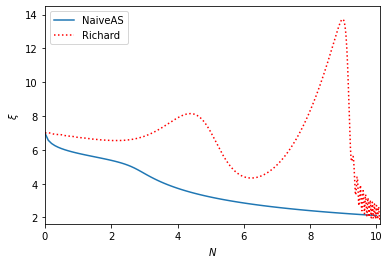

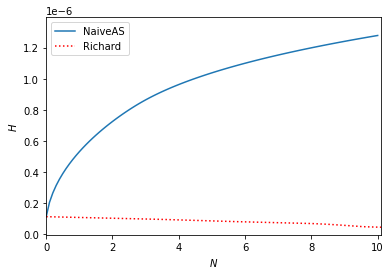

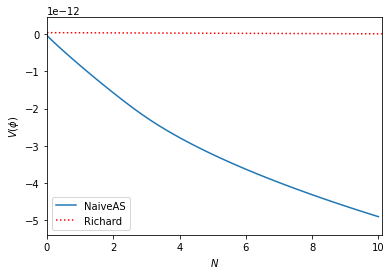

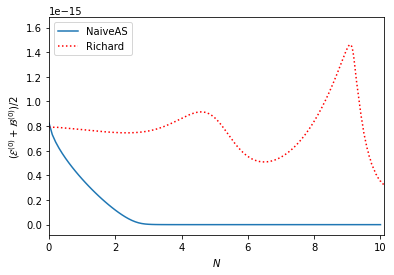

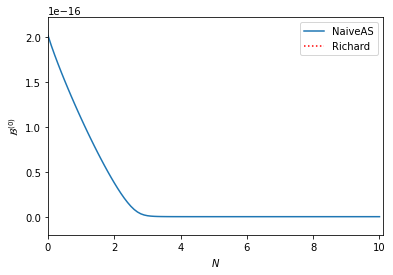

In [71]:
plt.plot(NS, xiS, label="NaiveAS")
plt.plot(NR, xiR, "r:", label="Richard")
plt.xlim(0, 10.0+0.1)
rg = max(xiS)-min(xiS)
plt.ylim(min(xiS)-0.1*rg, 14.0+0.1*rg)
plt.legend(loc=0)
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

plt.plot(NS, HS, label="NaiveAS")
plt.plot(NR, HR, "r:", label="Richard")
plt.xlim(0, max(NS)+0.1)
rg = max(HS)-min(HS)
plt.ylim(min(HS)-0.1*rg, max(HS)+0.1*rg)
plt.legend(loc=0)
plt.xlabel(r"$N$")
plt.ylabel(r"$H$")
plt.show()

plt.plot(NS, VS, label="NaiveAS")
plt.plot(NR, VR, "r:", label="Richard")
plt.xlim(0, max(NS)+0.1)
rg = max(VS)-min(VS)
plt.ylim(min(VS)-0.1*rg, max(VS)+0.1*rg)
plt.legend(loc=0)
plt.xlabel(r"$N$")
plt.ylabel(r"$V(\phi)$")
plt.show()

plt.plot(NS, EBS, label="NaiveAS")
plt.plot(NR, EBR, "r:", label="Richard")
plt.xlim(0, max(NS)+0.1)
rg = max(EBS)-min(EBS)
plt.ylim(min(EBS)-0.1*rg, 16e-16+0.1*rg)
plt.legend(loc=0)
plt.xlabel(r"$N$")
plt.ylabel(r"$(\mathcal{E}^{(0)}+\mathcal{B}^{(0)})/2$")
plt.show()


plt.plot(NS, GS, label="NaiveAS")
plt.plot(NR, GR, "r:", label="Richard")
plt.xlim(0, max(NS)+0.1)
rg = max(GS)-min(GS)
plt.ylim(min(GS)-0.1*rg, max(GS)+0.1*rg)
plt.legend(loc=0)
plt.xlabel(r"$N$")
plt.ylabel(r"$\mathcal{B}^{(0)}$")
plt.show()

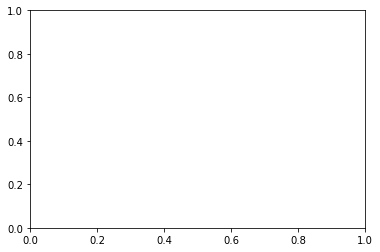

In [21]:
fig, ax = plt.subplots()

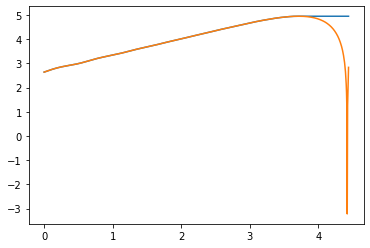

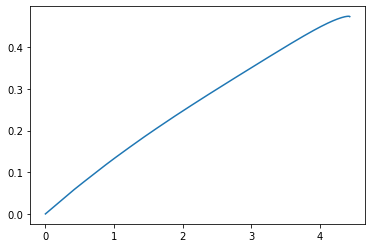

In [45]:
plt.plot(sol.y[0,:], sol.y[3,:])
plt.plot(sol.y[0,:], sol.y[0,:]+np.log(abs(sol.y[2,:])) + np.log(beta))
plt.show()
plt.plot(sol.y[0,:], sol.y[1,:])
plt.show()

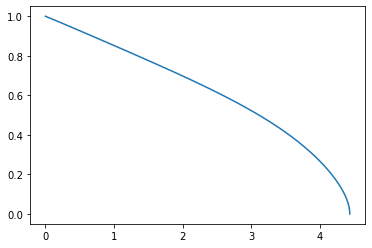

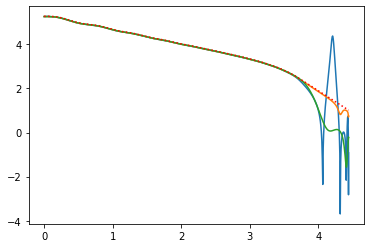

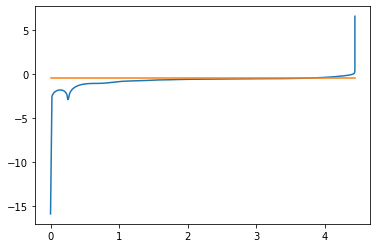

In [44]:
V = potential(sol.y[1,:]*f)/(omega**2*f**2)

Hsq = FriedmannEq(np.exp(sol.y[0,:]), sol.y[2,:], V, sol.y[4,:], sol.y[5,:], f, omega/f)
plt.plot(sol.y[0,:], np.sqrt(Hsq))
plt.show()
plt.plot(sol.y[0,:], np.log(abs(sol.y[-4,:]/sol.y[-10,:])))
plt.plot(sol.y[0,:], np.log(abs(sol.y[-5,:]/sol.y[-11,:])))
plt.plot(sol.y[0,:], np.log(abs(sol.y[-6,:]/sol.y[-12,:])))
plt.plot(sol.y[0,:], 2*(sol.y[3,:]-sol.y[-0,:]), "r:")
plt.show()
plt.plot(sol.y[0,:], np.log10(abs(beta*sol.y[2,:]/(2*np.sqrt(Hsq))-7.)/7.))
plt.plot(sol.y[0,:], np.ones(len(sol.y[0,:]))*(-0.5))
plt.show()

# Const H Anber Sorbo

In [172]:
HConst = 1
xi = 7
beta = 100
F, lnkh, V0, Vprime, dIdphi, f, omega = SetupConstH(xi, beta, 1., ntr, file="ConstH_xi_7_Initialiser.dat")
dVini = Vprime
print(f)
print(omega)
print(Vprime)
print(Vprime/(f*omega**2))

yini = np.zeros(2+3*ntr)
yini[0] = 7
yini[1] = lnkh -
yini[2:] = F

2e-07
1411683337885.6648
1.0
2e-07
-2.4266933406170634e-13
-6.066733351542659


In [173]:

func = lambda t, x: ConstHGEF(x, t, HConst, dVini, dIdphi, omega=omega, f=Mpl, approx=False)
#print(dVini)
#print(yini[2:5])
#print(yini[5:8])
#dydtini = func(0, yini)
#print("out: ", dydtini[2:5])

In [174]:
print(np.shape(yini.T))

sol = solve_ivp(func, [0, 50] , yini)

(572,)


In [175]:
print(Mpl**2/2*(Vprime/V0)**2)

5.899476200157551e+13


(572, 3259)


/tmp/ipykernel_4554/386584329.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(sol.t, np.log10(abs(sol.y[0,:]-7)/7))


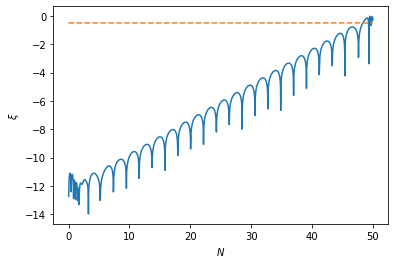

In [176]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log10(abs(sol.y[0,:]-7)/7))
plt.plot(sol.t, np.ones(len(sol.t))*(-0.5), "--")
#plt.plot(sol.t, 7.0*np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 9.21*np.ones(len(sol.t)), "y--")
#plt.plot(sol.t, 4.79*np.ones(len(sol.t)), "y--")
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

(572, 3258)


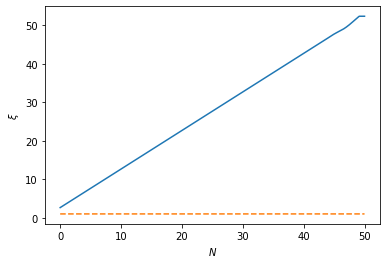

In [87]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, (sol.y[1,:]))
plt.plot(sol.t, np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 7.0*np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 9.21*np.ones(len(sol.t)), "y--")
#plt.plot(sol.t, 4.79*np.ones(len(sol.t)), "y--")
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

In [93]:
def getNCut(t, xi, xi0, prec=10**(-0.5)):
    for i in range(len(xi)):
        diff = abs(xi[i]-xi0)/xi0
        if (diff > prec):
            return t[i]
    return False

def NCutbyDelta(t, yini, vals, prec=10**(-0.5)):
    xi0 = yini[0]
    print(xi0)
    print(np.arange(1, vals))
    delta = 1/10**(np.arange(1, vals+1))
    xis = (delta+1)*xi0
    print(xis)
    NCut = []
    #delta = []
    for i in range(vals):
        yini[0] = xis[i]
        #sol = solve_ivp(func, [t[0], t[-1]] , yini)
        #NCut.append(getNCut(sol.t, sol.y[0,:], xi0, prec=10**(-0.5)))
    yini[0] = xi0
    delta = list(delta)
    return delta, NCut

def PlotNCutvsDelta(xi0, style="r."):
    file = "NCut_xi_" + str(xi0) + ".dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(delta, NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$|\xi-\xi_0|$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def PlotNCutvsDeltaLog(xi0, I, style="r."):
    filebeg = "NCut_xi_" + str(xi0) + "_del"
    filend = "_I" + str(I) + "_log.dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(np.log10(delta), NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$\log_{10}(|\xi-\xi_0|)$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def ReadFile(xi0, I, delta=None):
    filebeg = "Out_" + str(xi0) "_"
    filend = "_I" + str(I) + "_log.dat"
    if (delta == None):
        filename = filebeg + "base" + filend
    else:
        filename = filebeg + "del" + str(delta) + filend

    pwd = os.getcwd()
    path = os.path.join(pwd, filename)
    file = os.path.exists(path)
    if (not file):
        "There is no such file"
        return
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        t = data[:,1]
        y = data[:,2:]
    return t, y

In [63]:
print(NCutbyDelta(t, yini, 10))

7.000000007000001
[1 2 3 4 5 6 7 8 9]
[7.70000001 7.07000001 7.00700001 7.00070001 7.00007001 7.00000701
 7.00000071 7.00000008 7.00000001 7.00000001]
([0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10], [])


In [99]:
#Plus Sol
print(getNCut(sol.t, sol.y[0,:], 7.0))

1.0778432079856222e+01


In [94]:
print(getNCut(sol.t, sol.y[0,:], 7.0))

8.812767894971508e+00


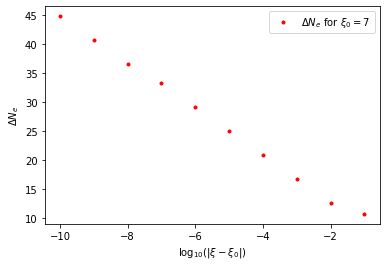

In [65]:
PlotNCutvsDeltaLog(7)

(596, 3671)


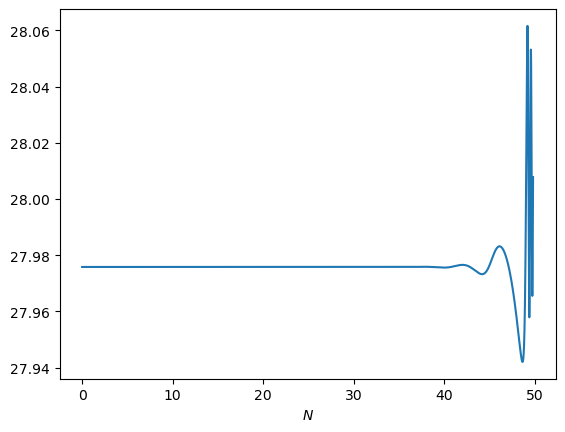

In [31]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log(abs(sol.y[4,:])))
plt.xlabel(r"$N$")
plt.show()

In [98]:
def ComputeEEBB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EEBB = quad(f, 0, kh)[0]
    return EEBB

def ComputeEB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EB = quad(f, 0, kh)[0]
    return EB

def GetIntEB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    return k**2 * a**-3 * H/(4*np.pi**2 ) * (expterm[0]*GtermPlus
                                             - expterm[1]*GtermMinus)

def GetIntEEBB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    EtermPlus = abs((1j*k/(a*H) - 1j*x) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/(a*H) - 1j*x) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    E = k * a**-2 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    B = k**3 * a**-4 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    
    return (E + B)/2

In [99]:
ComputeEB(1, 1, 1)/(np.exp(2*np.pi))
ComputeEEBB(1, 1, 1)/(np.exp(2*np.pi))

0.002005904173288318

In [85]:
H = 1
a = 1


EBcut = lambda x: ComputeEB(x, a, H)/(np.exp(2*np.pi*x)/x**4)

x = np.linspace(1, 100, 100)

EBapprox = np.ones(x.size)*(2.6e-4*H**4)

Eres = np.array([EBcut(x[i]) for i in range(x.size)]) 



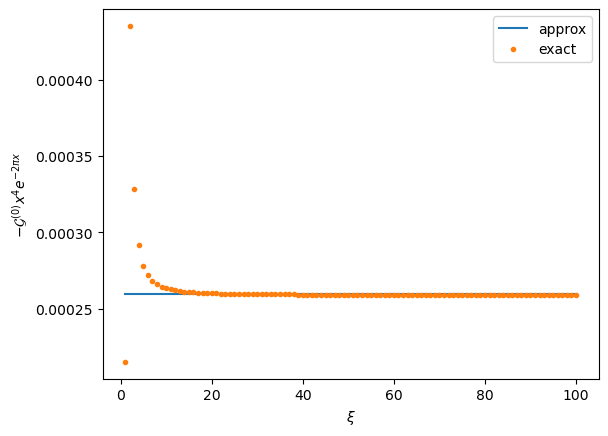

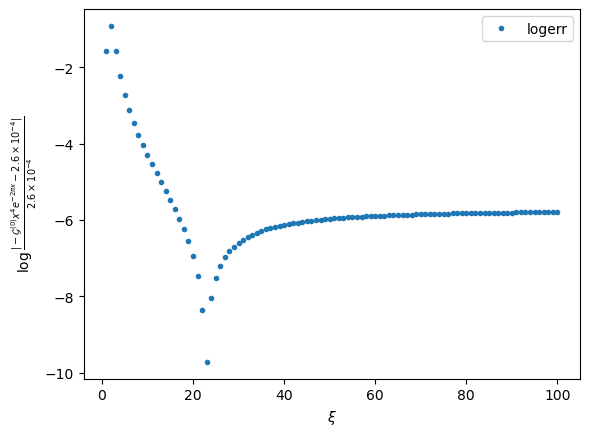

In [113]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EBapprox, label="approx")
plt.plot(x, Eres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$-\mathcal{G}^{(0)} x^4 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EBapprox-Eres)/abs(Eres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|-\mathcal{G}^{(0)} x^4 e^{-2 \pi x} - 2.6 \times 10^{-4}|}{2.6 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [100]:
EEBBcut = lambda x: ComputeEEBB(x, a, H)/(np.exp(2*np.pi*x)/x**3)

x = np.linspace(1, 100, 100)

EEBBapprox = np.ones(x.size)*(1.4e-4*H**4)

EEBBres = np.array([EEBBcut(x[i]) for i in range(x.size)]) 


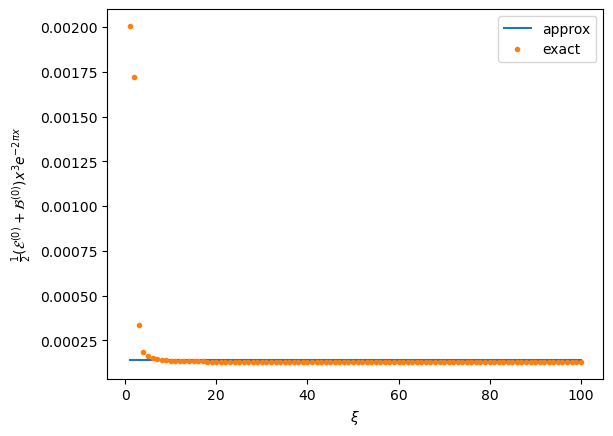

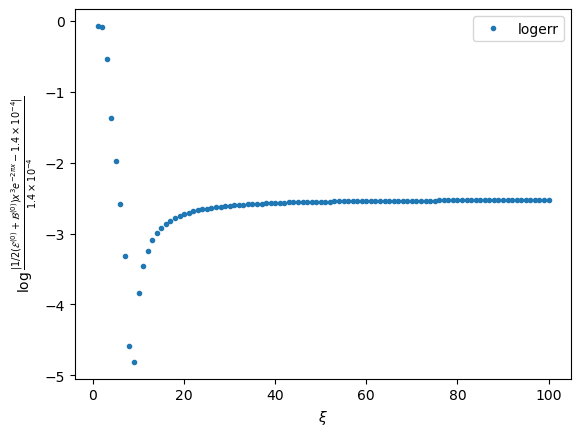

In [117]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EEBBapprox, label="approx")
plt.plot(x, EEBBres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\frac{1}{2}(\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EEBBapprox-EEBBres)/abs(EEBBres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|1/2 (\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}- 1.4 \times 10^{-4}|}{1.4 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [23]:
comp = yini[2:].reshape(192,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('InitCond_xi7.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(192):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[1.22551825e-09 1.12831344e-09 9.37223439e-10]
 [1.14314803e-09 8.85938454e-10 4.32646654e-10]
 [8.31348357e-10 2.45508387e-10 7.26026071e-10]
 [1.92389456e-09 1.15275269e-09 3.02113475e-09]
 [1.56837710e-09 3.67614934e-09 7.44625259e-09]
 [2.37948354e-07 7.98032743e-09 1.52766278e-08]
 [9.01332610e-09 1.50761111e-08 3.07870858e-08]
 [2.59758542e-09 2.56157048e-08 4.71519559e-08]
 [3.23659202e-08 3.83040889e-08 6.51343682e-08]
 [9.17906374e-08 4.68078977e-08 5.61004380e-08]
 [6.57617556e-08 4.59984692e-08 4.34541278e-08]
 [1.04700455e-05 3.63798343e-08 2.71934914e-08]
 [2.65801238e-08 2.55038509e-08 1.77859364e-08]
 [6.15745869e-06 1.63392493e-08 9.84999963e-09]
 [9.18144872e-09 1.02913945e-08 5.90604248e-09]
 [3.90383754e-07 6.24336435e-09 3.62115153e-09]
 [2.94963417e-09 3.89469185e-09 1.91634939e-09]
 [2.45608481e-07 2.19975237e-09 1.12351284e-09]
 [1.12587660e-09 1.24206541e-09 5.74817268e-10]
 [3.82454796e-07 6.94780267e-10 3.22745290e-10]
 [5.59758048e-10 3.69146194e-10 1.485344

In [169]:
comp = dydtini[2:].reshape(198,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('Tab_deriv_198.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(198):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[0.00000000e+00 9.20167932e-01 1.15249905e+01]
 [4.00608926e-05 4.69877919e+00 8.24379094e-01]
 [3.82738494e-04 9.60604803e-01 2.17856176e+01]
 [1.71648164e-01 1.47280967e+00 1.28894590e+00]
 [8.75671527e-01 1.03345199e+00 1.24650732e+00]
 [2.44736842e+00 9.84547490e-01 9.99871523e-01]
 [9.95420815e-01 1.00095079e+00 1.00035789e+00]
 [9.99594844e-01 9.99991709e-01 1.00000428e+00]
 [9.99997263e-01 1.00000000e+00 1.00000012e+00]
 [9.99998525e-01 9.99998734e-01 9.99999185e-01]
 [9.99999940e-01 1.00000029e+00 1.00000014e+00]
 [9.99999890e-01 1.00000001e+00 1.00000015e+00]
 [9.99999990e-01 1.00000107e+00 9.99999865e-01]
 [1.00000004e+00 9.99999814e-01 1.00000007e+00]
 [1.00000732e+00 9.99975840e-01 9.99999651e-01]
 [1.00001192e+00 9.99995895e-01 1.00000340e+00]
 [9.99998990e-01 9.99998629e-01 1.00000031e+00]
 [1.00000058e+00 9.99999889e-01 9.99999921e-01]
 [9.99999954e-01 9.99999956e-01 1.00000001e+00]
 [9.99999965e-01 9.99999969e-01 1.00000001e+00]
 [9.99999986e-01 9.99999959e-01 9.999999

In [31]:
n = np.random.randint(200, 300)
n=26
print(n)
dataN = np.array(ComputeEBGn(7., 1., 1., n))
print(dataN)
print(data[n,1:])
dataN[[1,2]] = dataN[[2,1]]
print(CompareData(n, dataN, data))

26
[3.66679423e+31 1.06650851e+32 1.59509134e+31]
[5.63585790e+23 2.54284819e+25 2.38979299e+23]
(array([6.50618636e+07, 6.27284321e+05, 4.46276522e+08]), array([6.50618646e+07, 6.27285321e+05, 4.46276523e+08]))


In [46]:
Names = ["n", "E", "B", "G"]
Data = yini[2:].reshape(100, 3)

DataDic = dict(E = list(Data[:,0]), B = list(Data[:,1]), G = list(Data[:,2]))
import pandas as pd
output_df = pd.DataFrame(DataDic)  
output_df.to_csv('output_file_name.dat')

input_df = pd.read_table('output_file_name.dat', sep=",") 
print(input_df.values[:,1])

[ 9.65018236e+012  2.49912527e+012  1.04739809e+012  6.52372520e+011
  5.70831966e+011  6.75023998e+011  1.05236970e+012  2.10847385e+012
  5.69972190e+012  1.65052837e+013  1.13111323e+014  1.25428976e+014
  8.83932193e+015 -2.89653393e+016  1.24547152e+018 -7.02762401e+018
  2.04548927e+020 -1.36812834e+021  3.52956063e+022 -2.55064903e+023
  6.23117710e+024 -4.70164605e+025  1.11519034e+027 -8.64701907e+027
  2.01488900e+029 -1.59173356e+030  3.66679423e+031 -2.93611407e+032
  6.71174459e+033 -5.42939507e+034  1.23444736e+036 -1.00656509e+037
  2.27974983e+038 -1.87075957e+039  4.22514428e+040 -3.48519325e+041
  7.85502664e+042 -6.50737121e+043  1.46437779e+045 -1.21755669e+046
  2.73672990e+047 -2.28252020e+048  5.12599555e+049 -4.28669374e+050
  9.62059546e+051 -8.06413070e+052  1.80894639e+054 -1.51939003e+055
  3.40707955e+056 -2.86689151e+057  6.42706853e+058 -5.41678020e+059
  1.21413208e+061 -1.02475621e+062  2.29665335e+063 -1.94094888e+064
  4.34971349e+065 -3.68035487e+066

In [5]:
HoverMpl = lambda beta, xi: 2e-7*(beta/100)**(-1/2)*np.exp(-2.85*(xi-7))

In [8]:
beta = 10**np.array([1.5, 3.5])
xi = np.array([5,9])

In [16]:
HoverMpl(beta, xi)
from scipy.optimize import fsolve
f = lambda x: HoverMpl(x, 7) - 



SyntaxError: invalid syntax (2749062437.py, line 1)

In [1]:
import numpy as np
print(np.arange(1, 16)[1:])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [17]:
2.2e-18*6.58e-16

1.4476e-33

In [23]:
beta = 2.45e-5*1.63e-7

In [21]:
HoverMpl(2.45e-5*1.63e-7, 7)

1.0008134915772269e+00

In [3]:
2.45/4

0.6125

In [8]:
HoverMpl(2.45e-5*6.125e6, 7)

1.63265306122449e-07

In [9]:
1/6.125e6

1.63265306122449e-07

76.0


In [37]:

"""yini = np.zeros(100*3+4)
print(yini.shape)
Mpl = 1
M = 6e-6*Mpl
yini[1] = 15.55
yini[2] = - np.sqrt(2/3)*M
Vini = potential(yini[1]*Mpl)
print(Vini)
print(omega)
yini[0] = 0
Iini = Mpl*dIdphi(Mpl*yini[1])
xi = GetXi(yini[2], Iini, 1.0)
print(xi)
yini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*1.0)"""

"""Use beta =10 No back reaction at all (since small coupling), then you should get chaotic inflation,
can be derived analytically, compare. Maybe beta = 0, to check pure chaotic inflation?"""

(304,)
4.352445000000001e-09
3.814203717684728e-05
-2.449489742783178e-05


'Use beta =10 No back reaction at all (since small coupling), then you should get chaotic inflation,\ncan be derived analytically, compare. Maybe beta = 0, to check pure chaotic inflation?'

In [19]:
"""
beta = 31.6
yini = np.zeros(150*3+4)
print(yini.shape)
Mpl = 1
yini[1] = 15.55 * Mpl
yini[2] = 3.5*M*Mpl
Vini = potential(yini[1])
print(Vini)
Hini = np.sqrt( (1/(3*Mpl)) * (0.5 * yini[2]**2 + Vini ) )
print(Hini**2)
yini[0] = 0
Iini = dIdphi(yini[1])
xi = GetXi(yini[2], Iini, Hini)
print(xi)
yini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*Hini)
"""

'\nbeta = 31.6\nyini = np.zeros(150*3+4)\nprint(yini.shape)\nMpl = 1\nyini[1] = 15.55 * Mpl\nyini[2] = 3.5*M*Mpl\nVini = potential(yini[1])\nprint(Vini)\nHini = np.sqrt( (1/(3*Mpl)) * (0.5 * yini[2]**2 + Vini ) )\nprint(Hini**2)\nyini[0] = 0\nIini = dIdphi(yini[1])\nxi = GetXi(yini[2], Iini, Hini)\nprint(xi)\nyini[3] = np.log(1.0*(1-alpha)*2*abs(xi)*Hini)\n'